# Uso da API do PCDaS

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import getpass
from PCDaS_API import API
sns.set()

In [ ]:
from IPython.display import clear_output

token = getpass.getpass('Digite o seu token para acesso a API:')

clear_output()

In [ ]:
acesso = API(token)

In [ ]:
acesso.check_datasets()['databases']

['datasus-sim',
 'datasus-sinasc',
 'datasus-sih',
 'datasus-pop',
 'datasus-cnes',
 'datasus-sim-dofet']


# Sistema de Informações sobre Mortalidade (SIM)

### Install

In [ ]:
pip install xgboost

In [ ]:
pip install matplotlib

In [ ]:
pip install prophet

### Import

In [ ]:
import pandas as pd
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from prophet import Prophet
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from google.colab import files

## Análise das Tendências de Suicídio no Brasil: Aspectos Sociodemográficos e o Efeito da Pandemia de COVID-19

#### SQL e Tratamento

In [ ]:
# sql_query = '''
# SELECT ano_obito, data_obito, CAUSABAS, SEXO, RACACOR, ESC, def_loc_ocor, res_MUNNOME, ocor_SIGLA_UF, idade_obito_anos
#     FROM "datasus-sim"
#     WHERE (CAUSABAS LIKE 'X6%' OR CAUSABAS LIKE 'X7%' OR CAUSABAS LIKE 'X8%' OR CAUSABAS LIKE 'Y870')
#     AND (ano_obito BETWEEN 2003 AND 2023)
# '''

# df_sql = acesso.query_with_sql(sql_query)
# df_sql

1 20000,2 30000,3 40000,4 50000,5 60000,6 70000,7 80000,8 90000,9 100000,10 110000,11 120000,12 130000,13 140000,14 150000,15 160000,16 170000,17 180000,18 190000,19 200000,20 210000,21 219186,22 219186,

/content/PCDaS_API.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_total = pd.concat(


ano_obito                data_obito CAUSABAS SEXO RACACOR ESC  \
0         2022  2022-05-05T00:00:00.000Z     X700    1       1   9   
1         2019  2019-10-17T00:00:00.000Z     X708    1       4   9   
2         2019  2019-05-19T00:00:00.000Z     X700    1       1   3   
3         2022  2022-04-07T00:00:00.000Z     X704    1       4   3   
4         2019  2019-04-23T00:00:00.000Z     X680    1       4   3   
...        ...                       ...      ...  ...     ...  ..   
9181      2010  2010-12-24T00:00:00.000Z     X700    1       5   3   
9182      2010  2010-11-21T00:00:00.000Z     X699    1       4   3   
9183      2010  2010-12-29T00:00:00.000Z     X700    2       5   3   
9184      2010  2010-12-17T00:00:00.000Z     X708    1       5   4   
9185      2010  2010-12-25T00:00:00.000Z     X708    1       5   4   

     def_loc_ocor            res_MUNNOME ocor_SIGLA_UF  idade_obito_anos  
0       Domicílio           Nova Bréscia            RS              60.0  
1          Outros                 Coreaú            CE              27.0  
2       Domicílio                Caucaia            CE              29.0  
3     Via Pública              Três Rios            RJ              41.0  
4        Hospital               Apuiarés            CE              42.0  
...           ...                    ...           ...               ...  
9181    Domicílio      Benjamin Constant            AM              45.0  
9182       Outros              Tabatinga            AM              29.0  
9183    Domicílio              Tabatinga            AM              12.0  
9184    Domicílio              Tabatinga            AM              24.0  
9185    Domicílio  São Paulo de Olivença            AM              20.0  

[219186 rows x 10 columns]

In [ ]:
# df_sql.to_csv('sim_versao_final.csv', index=False)

In [ ]:
# files.download('sim_versao_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_teste = pd.read_csv('sim_versao_final.csv')

In [ ]:
df_teste['ano_obito'].value_counts()

ano_obito
2022    16484
2021    15522
2020    13860
2019    13547
2018    12756
2017    12529
2016    11467
2015    11216
2014    10697
2013    10575
2012    10362
2011     9879
2010     9486
2009     9403
2008     9354
2007     8892
2006     8662
2005     8569
2004     8038
2003     7888
Name: count, dtype: int64

In [ ]:
count_x84_plus = df_teste[df_teste['CAUSABAS'].str.contains('^X8[5-9][0-9]*', na=False)].shape[0]

print(f"Quantidade de linhas começando com X84 ou maior: {count_x84_plus}")

Quantidade de linhas começando com X84 ou maior: 472


In [ ]:
df_teste = df_teste[
    ~df_teste['CAUSABAS'].str.contains('^X8[5-9][0-9]*', na=False)
]


In [ ]:
df_teste.shape

(218714, 10)

In [ ]:
df_teste.isnull().sum()

ano_obito             0
data_obito            0
CAUSABAS              0
SEXO                  0
RACACOR               0
ESC                   0
def_loc_ocor          0
res_MUNNOME           0
ocor_SIGLA_UF         0
idade_obito_anos    519
dtype: int64

In [ ]:
df_teste['ano_obito'].value_counts()

ano_obito
2022    16468
2021    15507
2020    13841
2019    13523
2018    12741
2017    12507
2016    11438
2015    11187
2014    10660
2013    10538
2012    10328
2011     9856
2010     9454
2009     9379
2008     9333
2007     8871
2006     8643
2005     8554
2004     8021
2003     7865
Name: count, dtype: int64



Obs.: Valores compatíveis com o DATASUS

In [ ]:
df_teste['data_obito'] = df_teste['data_obito'].str.replace('T00:00:00.000Z', '')

In [ ]:
df_teste

ano_obito  data_obito CAUSABAS  SEXO  RACACOR  ESC def_loc_ocor  \
0            2022  2022-05-05     X700     1        1    9    Domicílio   
1            2019  2019-10-17     X708     1        4    9       Outros   
2            2019  2019-05-19     X700     1        1    3    Domicílio   
3            2022  2022-04-07     X704     1        4    3  Via Pública   
4            2019  2019-04-23     X680     1        4    3     Hospital   
...           ...         ...      ...   ...      ...  ...          ...   
219181       2010  2010-12-24     X700     1        5    3    Domicílio   
219182       2010  2010-11-21     X699     1        4    3       Outros   
219183       2010  2010-12-29     X700     2        5    3    Domicílio   
219184       2010  2010-12-17     X708     1        5    4    Domicílio   
219185       2010  2010-12-25     X708     1        5    4    Domicílio   

                  res_MUNNOME ocor_SIGLA_UF  idade_obito_anos  
0                Nova Bréscia            RS              60.0  
1                      Coreaú            CE              27.0  
2                     Caucaia            CE              29.0  
3                   Três Rios            RJ              41.0  
4                    Apuiarés            CE              42.0  
...                       ...           ...               ...  
219181      Benjamin Constant            AM              45.0  
219182              Tabatinga            AM              29.0  
219183              Tabatinga            AM              12.0  
219184              Tabatinga            AM              24.0  
219185  São Paulo de Olivença            AM              20.0  

[218714 rows x 10 columns]

**NÚMERO DE INSTÂNCIAS DEVIDO: 218714**



In [ ]:
nan_instances = df_teste[df_teste['idade_obito_anos'].isna()]

print(nan_instances)

        ano_obito  data_obito CAUSABAS  SEXO  RACACOR  ESC def_loc_ocor  \
908          2022  2022-06-14     X804     1        4    9  Via Pública   
1289         2022  2022-10-31     X704     1        4    9       Outros   
1520         2020  2020-08-22     X805     2        4    9       Outros   
3932         2021  2021-01-17     X704     1        1    9  Via Pública   
4244         2022  2022-12-16     X709     1        1    9  Via Pública   
...           ...         ...      ...   ...      ...  ...          ...   
216476       2019  2019-04-04     X824     1        1    9  Via Pública   
216490       2018  2018-01-13     X704     1        9    9  Via Pública   
217751       2010  2010-07-15     X709     1        4    9  Via Pública   
218160       2013  2013-04-19     X804     1        4    9  Via Pública   
218618       2008  2008-12-19     X700     1        2    9    Domicílio   

                    res_MUNNOME ocor_SIGLA_UF  idade_obito_anos  
908     Município ignorado - SC  

Preenchendo idades que constam como NaN com a mediana.

In [ ]:
mediana_idade = df_teste['idade_obito_anos'].median()

df_teste['idade_obito_anos'].fillna(mediana_idade, inplace=True)

In [ ]:
df_teste.isna().sum()

ano_obito           0
data_obito          0
CAUSABAS            0
SEXO                0
RACACOR             0
ESC                 0
def_loc_ocor        0
res_MUNNOME         0
ocor_SIGLA_UF       0
idade_obito_anos    0
dtype: int64

In [ ]:
count_less_than_5 = df_teste[df_teste['idade_obito_anos'] < 5].shape[0]

print(f"Quantidade de instâncias com idade_obito_anos menor que 5: {count_less_than_5}")

instances_less_than_5 = df_teste[df_teste['idade_obito_anos'] < 5]
print(instances_less_than_5)


Quantidade de instâncias com idade_obito_anos menor que 5: 7
        ano_obito  data_obito CAUSABAS  SEXO  RACACOR  ESC def_loc_ocor  \
55604        2004  2004-02-07     X769     2        4    9     Hospital   
60914        2004  2004-10-09     X769     2        9    9     Hospital   
63942        2016  2016-02-05     X700     1        4    9     Hospital   
77944        2004  2004-11-22     X699     2        4    2     Hospital   
105702       2005  2005-01-06     X689     1        1    9     Hospital   
191619       2016  2016-06-09     X708     2        4    9    Domicílio   
205018       2005  2005-12-17     X718     1        4    1    Domicílio   

           res_MUNNOME ocor_SIGLA_UF  idade_obito_anos  
55604         Monteiro            PB               1.0  
60914      Juazeirinho            PB               1.0  
63942        Arapiraca            AL               0.0  
77944      Ibicuitinga            CE               3.0  
105702     São Fidélis            RJ               3.

In [ ]:
df_teste = df_teste[df_teste['idade_obito_anos'] >= 5]

print(df_teste.shape)

(218707, 10)


**NÚMERO DE INSTÂNCIAS DEVIDO: 218707**



In [ ]:
df_teste.to_csv('sim_limpo_e_alterado.csv', index=False)

#### Cálculo da taxa de mortalidade por suicídio a cada 100 mil habitantes

In [ ]:
df_populacao = pd.read_csv('pop.csv', sep=';')

df_populacao

2003       2004       2005       2006       2007       2008  \
0  176871437  181569056  184184264  186770562  183987291  189605006   

        2009       2010       2011       2012       2013       2014  \
0  191480630  190755799  192379287  193904015  201032714  202768562   

        2015       2016       2017       2018       2019       2020  \
0  204450049  206081432  207660929  208494900  210147125  211755692   

        2021       2022  
0  213317639  203080756

In [ ]:
df_populacao_novo = pd.DataFrame(columns=['ano', 'tam_pop'])

for coluna in df_populacao.columns[0:]:
  ano = int(coluna)
  populacao = df_populacao.loc[0, coluna]
  df_populacao_novo = pd.concat([df_populacao_novo, pd.DataFrame({'ano': [ano], 'tam_pop': [populacao]})], ignore_index=True)

df_populacao_novo


ano    tam_pop
0   2003  176871437
1   2004  181569056
2   2005  184184264
3   2006  186770562
4   2007  183987291
5   2008  189605006
6   2009  191480630
7   2010  190755799
8   2011  192379287
9   2012  193904015
10  2013  201032714
11  2014  202768562
12  2015  204450049
13  2016  206081432
14  2017  207660929
15  2018  208494900
16  2019  210147125
17  2020  211755692
18  2021  213317639
19  2022  203080756

In [ ]:
suicidios_por_ano = df_teste.groupby('ano_obito')['ano_obito'].count()

taxa_suicidio = pd.DataFrame()
taxa_suicidio['ano'] = suicidios_por_ano.index
taxa_suicidio['numero_suicidios'] = suicidios_por_ano.values

taxa_suicidio = pd.merge(taxa_suicidio, df_populacao_novo, on='ano', how='left')

taxa_suicidio['taxa_suicidio'] = (taxa_suicidio['numero_suicidios'] / taxa_suicidio['tam_pop']) * 100000

print(taxa_suicidio)


     ano  numero_suicidios    tam_pop taxa_suicidio
0   2003              7865  176871437      4.446733
1   2004              8018  181569056      4.415951
2   2005              8552  184184264      4.643176
3   2006              8643  186770562      4.627603
4   2007              8871  183987291      4.821529
5   2008              9333  189605006      4.922338
6   2009              9379  191480630      4.898146
7   2010              9454  190755799      4.956075
8   2011              9856  192379287      5.123213
9   2012             10328  193904015      5.326347
10  2013             10538  201032714      5.241933
11  2014             10660  202768562      5.257225
12  2015             11187  204450049      5.471752
13  2016             11436  206081432      5.549263
14  2017             12507  207660929      6.022799
15  2018             12741  208494900      6.110941
16  2019             13523  210147125      6.435015
17  2020             13841  211755692      6.536306
18  2021    

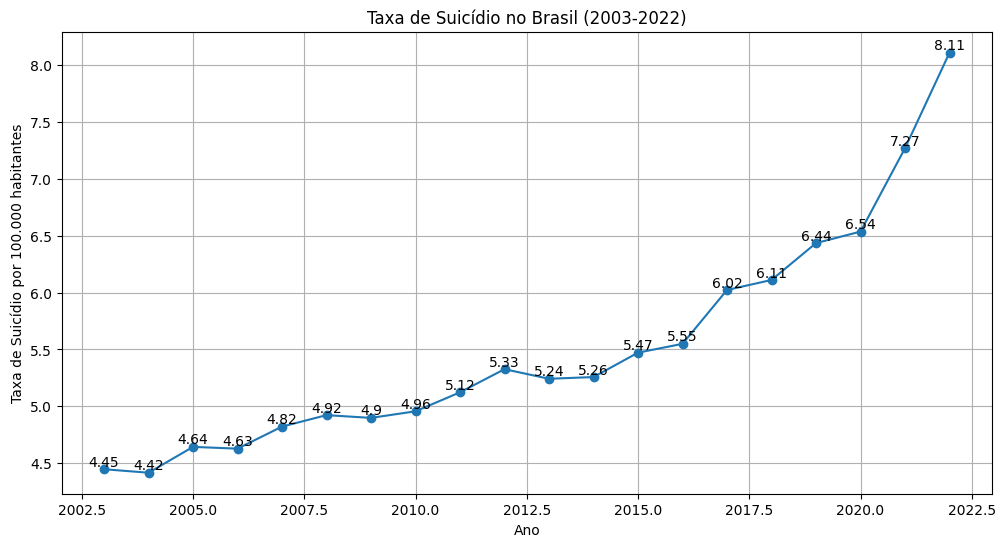

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(taxa_suicidio['ano'], taxa_suicidio['taxa_suicidio'], marker='o')
plt.xlabel('Ano')
plt.ylabel('Taxa de Suicídio por 100.000 habitantes')
plt.title('Taxa de Suicídio no Brasil (2003-2022)')
plt.grid(True)


for x, y in zip(taxa_suicidio['ano'], taxa_suicidio['taxa_suicidio']):
    plt.text(x, y, str(round(y, 2)), ha='center', va='bottom')

plt.savefig('Taxa de Suicídio no Brasil (2003-2022).png', format='png', dpi=300, bbox_inches='tight')

plt.show()

files.download('Taxa de Suicídio no Brasil (2003-2022).png')


#### Estatísticas

In [ ]:
df = pd.read_csv('sim_limpo_e_alterado.csv')

In [ ]:
df

ano_obito  data_obito CAUSABAS  SEXO  RACACOR  ESC def_loc_ocor  \
0            2022  2022-05-05     X700     1        1    9    Domicílio   
1            2019  2019-10-17     X708     1        4    9       Outros   
2            2019  2019-05-19     X700     1        1    3    Domicílio   
3            2022  2022-04-07     X704     1        4    3  Via Pública   
4            2019  2019-04-23     X680     1        4    3     Hospital   
...           ...         ...      ...   ...      ...  ...          ...   
218702       2010  2010-12-24     X700     1        5    3    Domicílio   
218703       2010  2010-11-21     X699     1        4    3       Outros   
218704       2010  2010-12-29     X700     2        5    3    Domicílio   
218705       2010  2010-12-17     X708     1        5    4    Domicílio   
218706       2010  2010-12-25     X708     1        5    4    Domicílio   

                  res_MUNNOME ocor_SIGLA_UF  idade_obito_anos  
0                Nova Bréscia            RS              60.0  
1                      Coreaú            CE              27.0  
2                     Caucaia            CE              29.0  
3                   Três Rios            RJ              41.0  
4                    Apuiarés            CE              42.0  
...                       ...           ...               ...  
218702      Benjamin Constant            AM              45.0  
218703              Tabatinga            AM              29.0  
218704              Tabatinga            AM              12.0  
218705              Tabatinga            AM              24.0  
218706  São Paulo de Olivença            AM              20.0  

[218707 rows x 10 columns]

In [ ]:
df['causa'] = df['CAUSABAS'].str[:3]

top_5_causabas = df['causa'].value_counts().head(5)

print(top_5_causabas)


causa
X70    142867
X74     14404
X68     10642
X80      8100
X72      5711
Name: count, dtype: int64


In [ ]:
top_locations = df['def_loc_ocor'].value_counts().head(10)
print(top_locations)


def_loc_ocor
Domicílio             130467
Hospital               36012
Outros                 34035
Via Pública            13433
Outro Estab. Saúde      3415
Ignorado                1345
Name: count, dtype: int64


In [ ]:
top_raca_cor = df['RACACOR'].value_counts()
print(top_raca_cor)


RACACOR
1    110257
4     86740
2     11704
9      6955
5      2189
3       862
Name: count, dtype: int64


In [ ]:
top_sexos = df['SEXO'].value_counts()
print(top_sexos)


SEXO
1    172107
2     46565
0        35
Name: count, dtype: int64


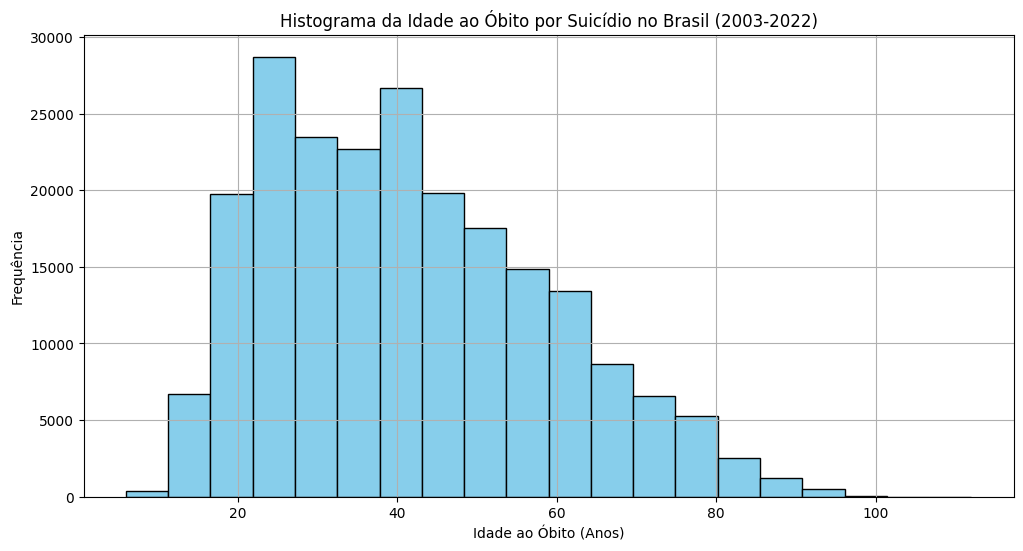

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(df_teste['idade_obito_anos'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Idade ao Óbito (Anos)')
plt.ylabel('Frequência')
plt.title('Histograma da Idade ao Óbito por Suicídio no Brasil (2003-2022)')
plt.grid(True)
plt.savefig('Histograma da Idade ao Óbito por Suicídio no Brasil (2003-2022).png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Histograma da Idade ao Óbito por Suicídio no Brasil (2003-2022).png')


In [ ]:
bins = [5, 14, 19, 29, 49, 69, float('inf')]
labels = ['5 a 14', '15 a 19', '20 a 29', '30 a 49', '50 a 69', '70 anos ou mais']

df['intervalo_idade'] = pd.cut(df['idade_obito_anos'], bins=bins, labels=labels, include_lowest=True)

contagem_idade = df['intervalo_idade'].value_counts()

print(contagem_idade)


intervalo_idade
30 a 49            86790
50 a 69            50768
20 a 29            47183
70 anos ou mais    16177
15 a 19            14988
5 a 14              2801
Name: count, dtype: int64


In [ ]:
print(df['ESC'].value_counts())

ESC
9    60445
3    50579
4    48998
2    29755
5    18570
1    10360
Name: count, dtype: int64


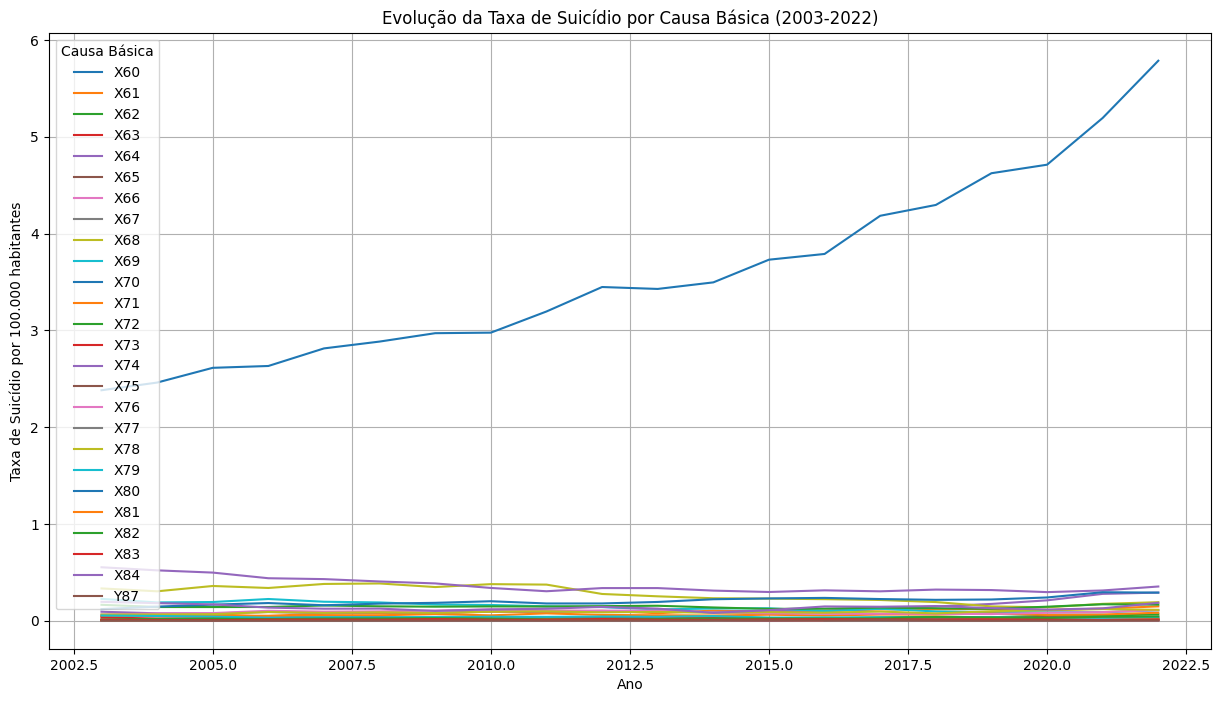

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
suicidios_por_causa_ano = df.groupby(['ano_obito', 'causa'])['ano_obito'].count().unstack()

taxa_suicidio_por_causa = pd.DataFrame()
for causa in suicidios_por_causa_ano.columns:
  temp_df = pd.DataFrame({'ano': suicidios_por_causa_ano.index, 'causa': causa, 'numero_suicidios': suicidios_por_causa_ano[causa]})
  temp_df = pd.merge(temp_df, df_populacao_novo, on='ano', how='left')
  temp_df['taxa_suicidio'] = (temp_df['numero_suicidios'] / temp_df['tam_pop']) * 100000
  taxa_suicidio_por_causa = pd.concat([taxa_suicidio_por_causa, temp_df])

plt.figure(figsize=(15, 8))
for causa in taxa_suicidio_por_causa['causa'].unique():
  subset = taxa_suicidio_por_causa[taxa_suicidio_por_causa['causa'] == causa]
  plt.plot(subset['ano'], subset['taxa_suicidio'], label=causa)

plt.xlabel('Ano')
plt.ylabel('Taxa de Suicídio por 100.000 habitantes')
plt.title('Evolução da Taxa de Suicídio por Causa Básica (2003-2022)')
plt.grid(True)
plt.legend(title='Causa Básica', loc='upper left')

plt.savefig('Evolução da Taxa de Suicídio por Causa Básica (2003-2022).png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Evolução da Taxa de Suicídio por Causa Básica (2003-2022).png')


In [ ]:
taxa_suicidio_por_causa

ano causa  numero_suicidios    tam_pop taxa_suicidio
0   2003   X60               5.0  176871437      0.002827
1   2004   X60               4.0  181569056      0.002203
2   2005   X60               7.0  184184264      0.003801
3   2006   X60               5.0  186770562      0.002677
4   2007   X60               6.0  183987291      0.003261
..   ...   ...               ...        ...           ...
15  2018   Y87               8.0  208494900      0.003837
16  2019   Y87               3.0  210147125      0.001428
17  2020   Y87               6.0  211755692      0.002833
18  2021   Y87               8.0  213317639       0.00375
19  2022   Y87               6.0  203080756      0.002954

[520 rows x 5 columns]

<ipython-input-58-2181a397e8d0>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby(['ano_obito', 'intervalo_idade'])['intervalo_idade'].count().unstack()


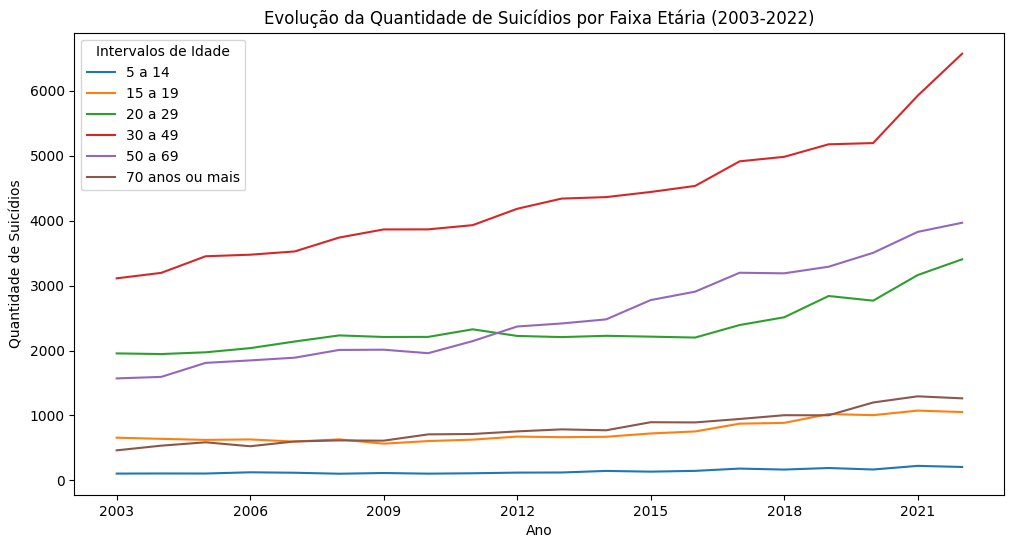

In [ ]:
bins = [5, 14, 19, 29, 49, 69, float('inf')]
labels = ['5 a 14', '15 a 19', '20 a 29', '30 a 49', '50 a 69', '70 anos ou mais']

df['intervalo_idade'] = pd.cut(df['idade_obito_anos'], bins=bins, labels=labels, include_lowest=True)

df_grouped = df.groupby(['ano_obito', 'intervalo_idade'])['intervalo_idade'].count().unstack()

df_grouped.plot(figsize=(12, 6))

plt.legend(title='Intervalos de Idade', loc='upper left')

plt.title('Evolução da Quantidade de Suicídios por Faixa Etária (2003-2022)')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Suicídios')

plt.xticks(df_grouped.index[::3])

plt.show()


<ipython-input-37-bc45c9ac26ba>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby(['ano_obito', 'intervalo_idade'])['intervalo_idade'].count().unstack()


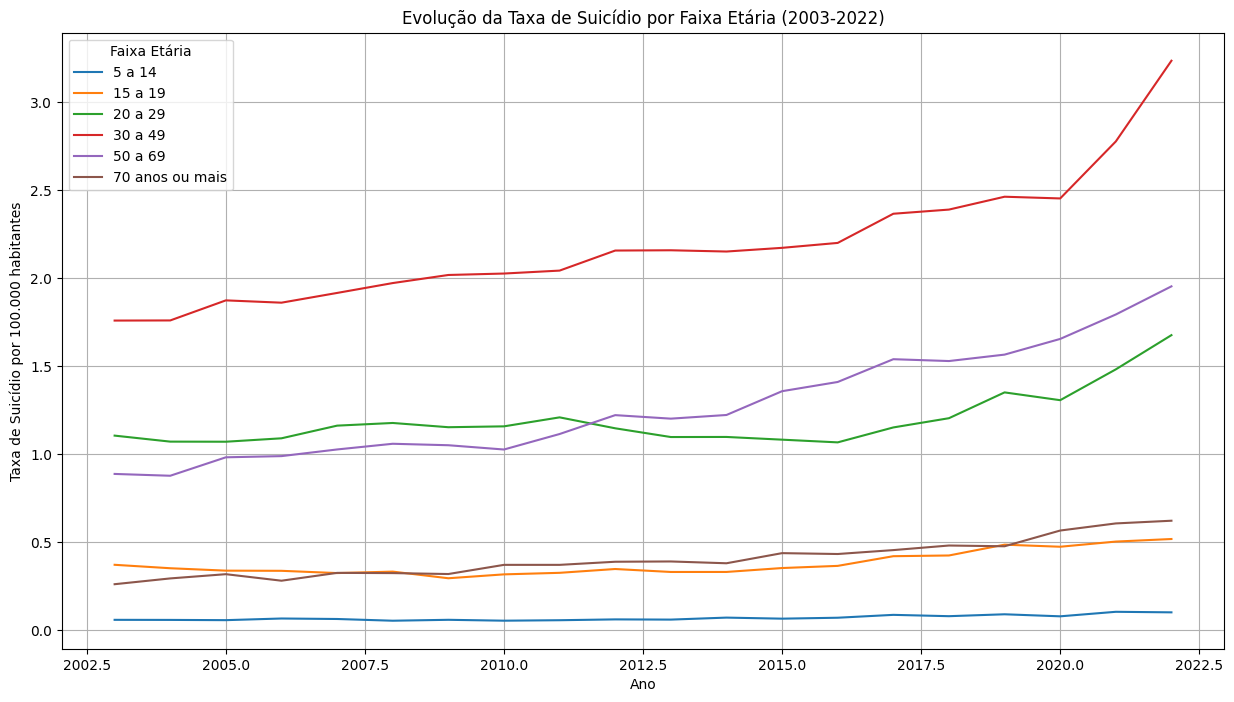

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_grouped = df.groupby(['ano_obito', 'intervalo_idade'])['intervalo_idade'].count().unstack()

taxa_suicidio_por_idade = pd.DataFrame()
for idade in df_grouped.columns:
  temp_df = pd.DataFrame({'ano': df_grouped.index, 'intervalo_idade': idade, 'numero_suicidios': df_grouped[idade]})
  temp_df = pd.merge(temp_df, df_populacao_novo, on='ano', how='left')
  temp_df['taxa_suicidio'] = (temp_df['numero_suicidios'] / temp_df['tam_pop']) * 100000
  taxa_suicidio_por_idade = pd.concat([taxa_suicidio_por_idade, temp_df])


plt.figure(figsize=(15, 8))
for idade in taxa_suicidio_por_idade['intervalo_idade'].unique():
  subset = taxa_suicidio_por_idade[taxa_suicidio_por_idade['intervalo_idade'] == idade]
  plt.plot(subset['ano'], subset['taxa_suicidio'], label=idade)

plt.xlabel('Ano')
plt.ylabel('Taxa de Suicídio por 100.000 habitantes')
plt.title('Evolução da Taxa de Suicídio por Faixa Etária (2003-2022)')
plt.grid(True)
plt.legend(title='Faixa Etária', loc='upper left')

plt.savefig('Evolução da Taxa de Suicídio por Faixa Etária (2003-2022).png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Evolução da Taxa de Suicídio por Faixa Etária (2003-2022).png')


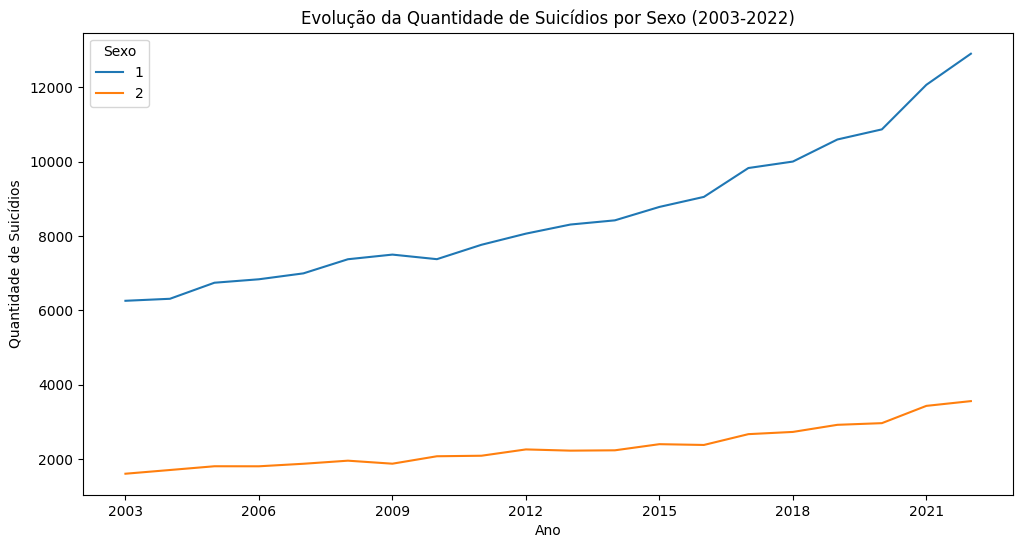

In [ ]:
df_grouped = df.groupby(['ano_obito', 'SEXO'])['SEXO'].count().unstack()

if 0 in df_grouped.columns:
  df_grouped = df_grouped.drop(columns=[0])

df_grouped.plot(figsize=(12, 6))

plt.legend(title='Sexo', loc='upper left')

plt.title('Evolução da Quantidade de Suicídios por Sexo (2003-2022)')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Suicídios')

plt.xticks(df_grouped.index[::3])

plt.show()


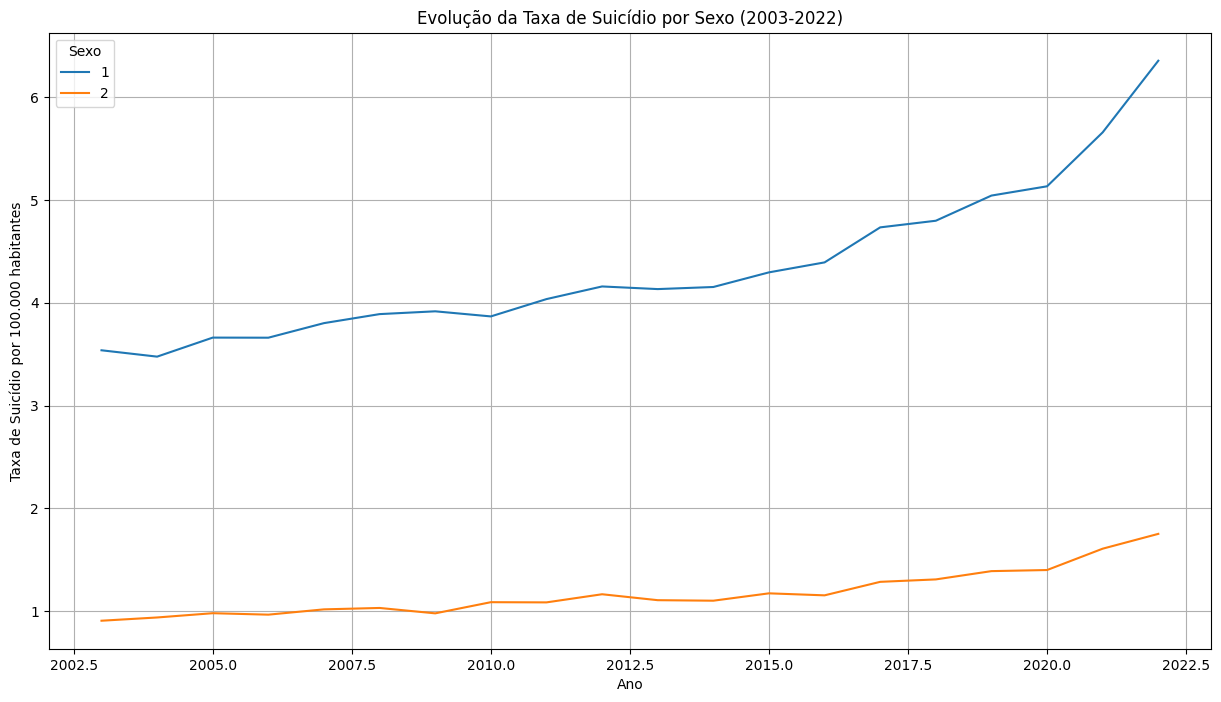

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_grouped = df.groupby(['ano_obito', 'SEXO'])['SEXO'].count().unstack()

if 0 in df_grouped.columns:
  df_grouped = df_grouped.drop(columns=[0])

taxa_suicidio_por_sexo = pd.DataFrame()
for sexo in df_grouped.columns:
  temp_df = pd.DataFrame({'ano': df_grouped.index, 'SEXO': sexo, 'numero_suicidios': df_grouped[sexo]})
  temp_df = pd.merge(temp_df, df_populacao_novo, on='ano', how='left')
  temp_df['taxa_suicidio'] = (temp_df['numero_suicidios'] / temp_df['tam_pop']) * 100000
  taxa_suicidio_por_sexo = pd.concat([taxa_suicidio_por_sexo, temp_df])


plt.figure(figsize=(15, 8))
for sexo in taxa_suicidio_por_sexo['SEXO'].unique():
  subset = taxa_suicidio_por_sexo[taxa_suicidio_por_sexo['SEXO'] == sexo]
  plt.plot(subset['ano'], subset['taxa_suicidio'], label=sexo)

plt.xlabel('Ano')
plt.ylabel('Taxa de Suicídio por 100.000 habitantes')
plt.title('Evolução da Taxa de Suicídio por Sexo (2003-2022)')
plt.grid(True)
plt.legend(title='Sexo', loc='upper left')

plt.savefig('Evolução da Taxa de Suicídio por Sexo (2003-2022).png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Evolução da Taxa de Suicídio por Sexo (2003-2022).png')


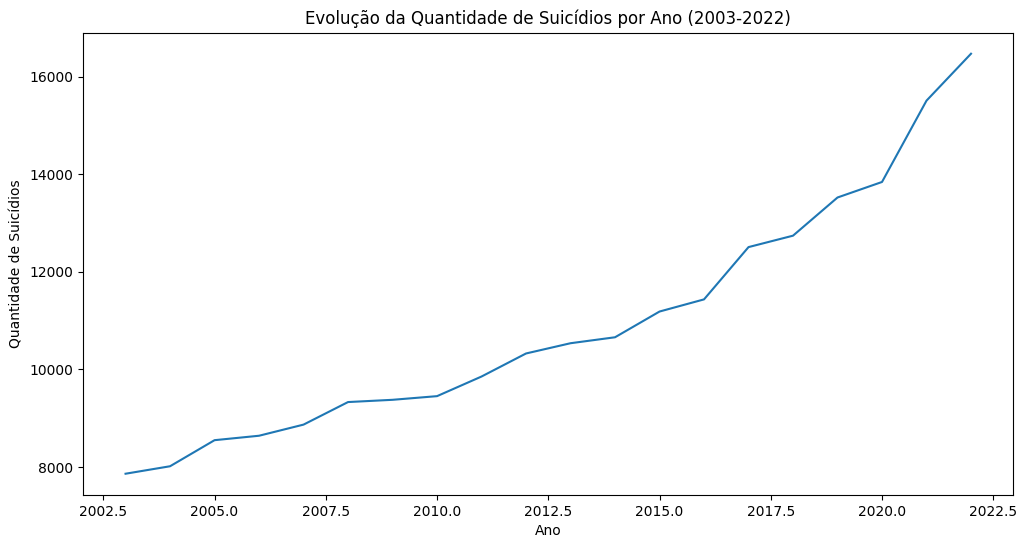

In [ ]:
df_grouped = df.groupby('ano_obito')['ano_obito'].count()

plt.figure(figsize=(12, 6))
plt.plot(df_grouped.index, df_grouped.values)

plt.title('Evolução da Quantidade de Suicídios por Ano (2003-2022)')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Suicídios')

plt.show()


In [ ]:
# prompt: top UFs por taxa de suicidio

import pandas as pd
df_grouped_uf = df.groupby(['ocor_SIGLA_UF'])['ocor_SIGLA_UF'].count()

taxa_suicidio_por_uf = pd.DataFrame()
taxa_suicidio_por_uf['uf'] = df_grouped_uf.index
taxa_suicidio_por_uf['numero_suicidios'] = df_grouped_uf.values

taxa_suicidio_por_uf = pd.merge(taxa_suicidio_por_uf, df_populacao_novo, left_on='uf', right_on='ano', how='left')

taxa_suicidio_por_uf['taxa_suicidio'] = (taxa_suicidio_por_uf['numero_suicidios'] / taxa_suicidio_por_uf['tam_pop']) * 100000

top_ufs = taxa_suicidio_por_uf.sort_values('taxa_suicidio', ascending=False).head(10)

print(top_ufs)


   uf  numero_suicidios  ano tam_pop taxa_suicidio
0  AC               925  NaN     NaN           NaN
1  AL              2329  NaN     NaN           NaN
2  AM              3860  NaN     NaN           NaN
3  AP               836  NaN     NaN           NaN
4  BA             10024  NaN     NaN           NaN
5  CE             11477  NaN     NaN           NaN
6  DF              3048  NaN     NaN           NaN
7  ES              3722  NaN     NaN           NaN
8  GO              8550  NaN     NaN           NaN
9  MA              4699  NaN     NaN           NaN


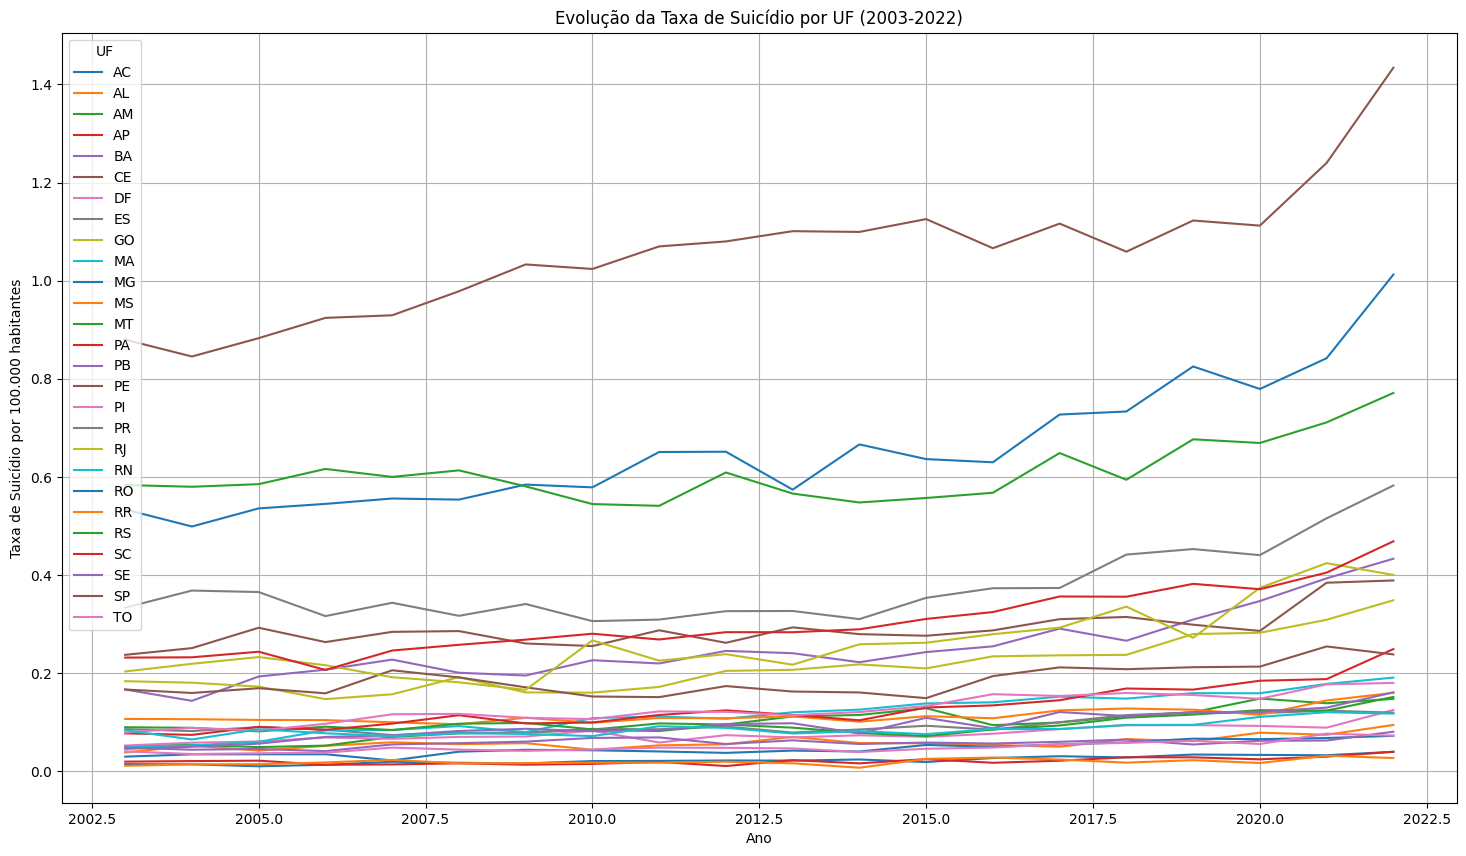

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_grouped = df.groupby(['ano_obito', 'ocor_SIGLA_UF'])['ocor_SIGLA_UF'].count().unstack()

taxa_suicidio_por_uf = pd.DataFrame()
for uf in df_grouped.columns:
  temp_df = pd.DataFrame({'ano': df_grouped.index, 'ocor_SIGLA_UF': uf, 'numero_suicidios': df_grouped[uf]})
  temp_df = pd.merge(temp_df, df_populacao_novo, on='ano', how='left')
  temp_df['taxa_suicidio'] = (temp_df['numero_suicidios'] / temp_df['tam_pop']) * 100000
  taxa_suicidio_por_uf = pd.concat([taxa_suicidio_por_uf, temp_df])


plt.figure(figsize=(18, 10))
for uf in taxa_suicidio_por_uf['ocor_SIGLA_UF'].unique():
  subset = taxa_suicidio_por_uf[taxa_suicidio_por_uf['ocor_SIGLA_UF'] == uf]
  plt.plot(subset['ano'], subset['taxa_suicidio'], label=uf)

plt.xlabel('Ano')
plt.ylabel('Taxa de Suicídio por 100.000 habitantes')
plt.title('Evolução da Taxa de Suicídio por UF (2003-2022)')
plt.grid(True)
plt.legend(title='UF', loc='upper left')

plt.savefig('Evolução da Taxa de Suicídio por UF (2003-2022).png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Evolução da Taxa de Suicídio por UF (2003-2022).png')


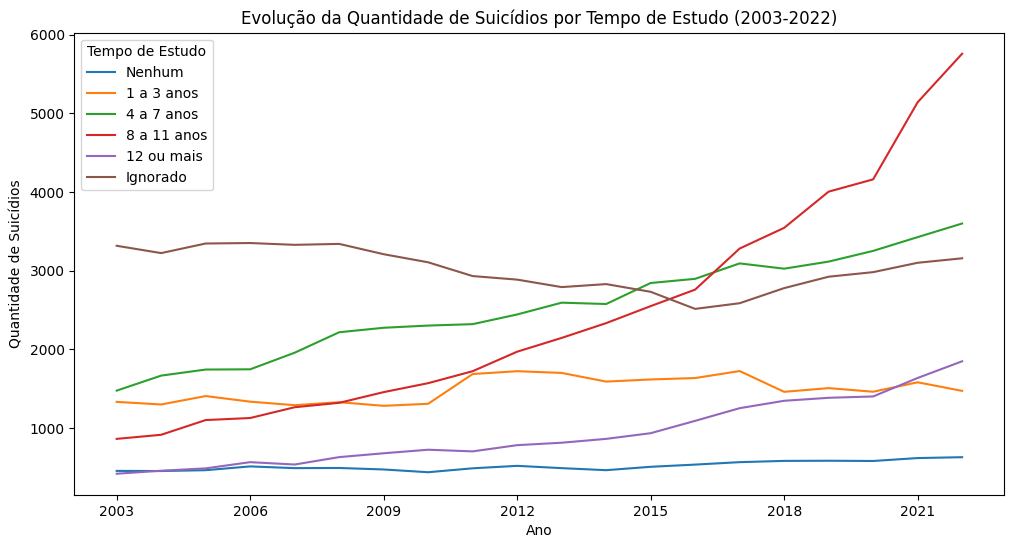

In [ ]:
df_grouped = df.groupby(['ano_obito', 'ESC'])['ESC'].count().unstack()

df_grouped = df_grouped.rename(
    columns={
        1: 'Nenhum',
        2: '1 a 3 anos',
        3: '4 a 7 anos',
        4: '8 a 11 anos',
        5: '12 ou mais',
        9: 'Ignorado'
    }
)

df_grouped.plot(figsize=(12, 6))

plt.legend(title='Tempo de Estudo', loc='upper left')

plt.title('Evolução da Quantidade de Suicídios por Tempo de Estudo (2003-2022)')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Suicídios')

plt.xticks(df_grouped.index[::3])

plt.show()


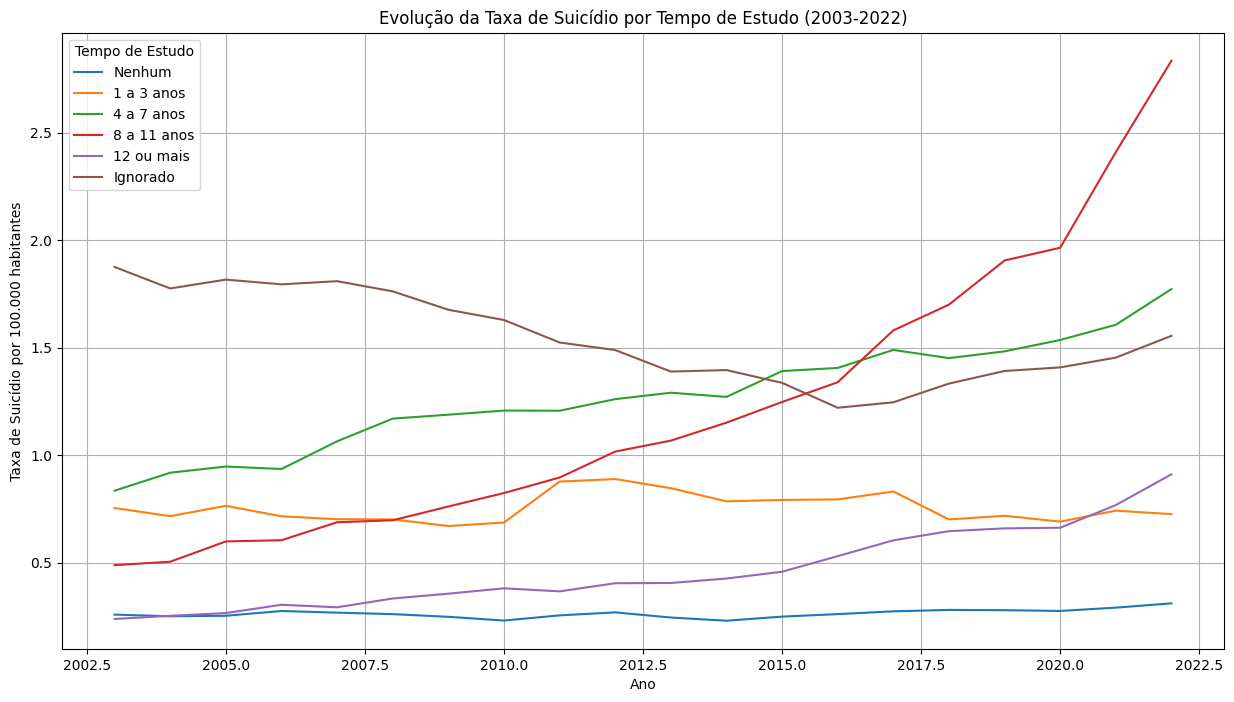

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_grouped = df.groupby(['ano_obito', 'ESC'])['ESC'].count().unstack()

df_grouped = df_grouped.rename(
    columns={
        1: 'Nenhum',
        2: '1 a 3 anos',
        3: '4 a 7 anos',
        4: '8 a 11 anos',
        5: '12 ou mais',
        9: 'Ignorado'
    }
)

taxa_suicidio_por_escolaridade = pd.DataFrame()
for escolaridade in df_grouped.columns:
  temp_df = pd.DataFrame({'ano': df_grouped.index, 'ESC': escolaridade, 'numero_suicidios': df_grouped[escolaridade]})
  temp_df = pd.merge(temp_df, df_populacao_novo, on='ano', how='left')
  temp_df['taxa_suicidio'] = (temp_df['numero_suicidios'] / temp_df['tam_pop']) * 100000
  taxa_suicidio_por_escolaridade = pd.concat([taxa_suicidio_por_escolaridade, temp_df])


plt.figure(figsize=(15, 8))
for escolaridade in taxa_suicidio_por_escolaridade['ESC'].unique():
  subset = taxa_suicidio_por_escolaridade[taxa_suicidio_por_escolaridade['ESC'] == escolaridade]
  plt.plot(subset['ano'], subset['taxa_suicidio'], label=escolaridade)

plt.xlabel('Ano')
plt.ylabel('Taxa de Suicídio por 100.000 habitantes')
plt.title('Evolução da Taxa de Suicídio por Tempo de Estudo (2003-2022)')
plt.grid(True)
plt.legend(title='Tempo de Estudo', loc='upper left')

plt.savefig('Evolução da Taxa de Suicídio por Tempo de Estudo (2003-2022).png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Evolução da Taxa de Suicídio por Tempo de Estudo (2003-2022).png')


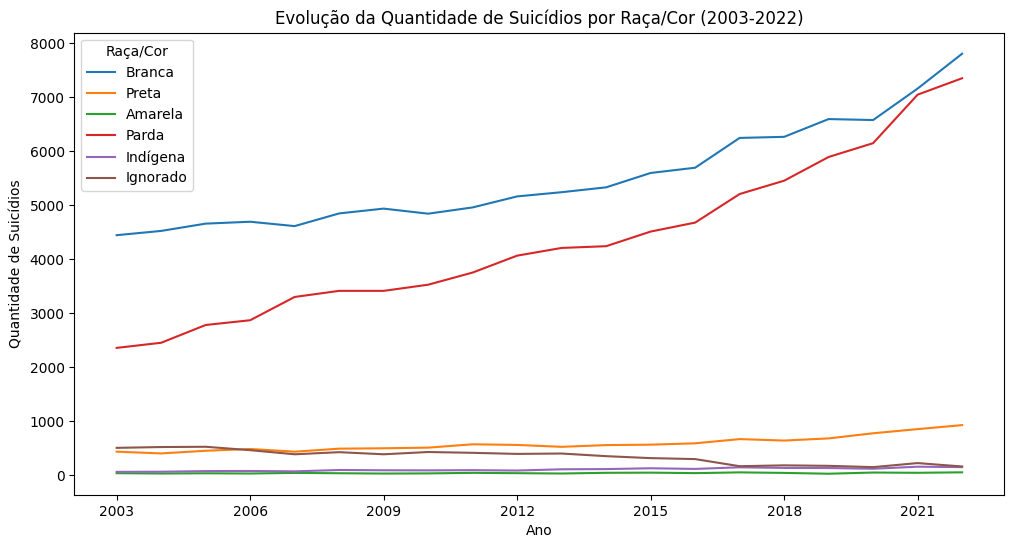

In [ ]:
df_grouped = df.groupby(['ano_obito', 'RACACOR'])['RACACOR'].count().unstack()

df_grouped = df_grouped.rename(
    columns={
        1: 'Branca',
        2: 'Preta',
        3: 'Amarela',
        4: 'Parda',
        5: 'Indígena',
        9: 'Ignorado'
    }
)

df_grouped.plot(figsize=(12, 6))

plt.legend(title='Raça/Cor', loc='upper left')

plt.title('Evolução da Quantidade de Suicídios por Raça/Cor (2003-2022)')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Suicídios')

plt.xticks(df_grouped.index[::3])

plt.show()


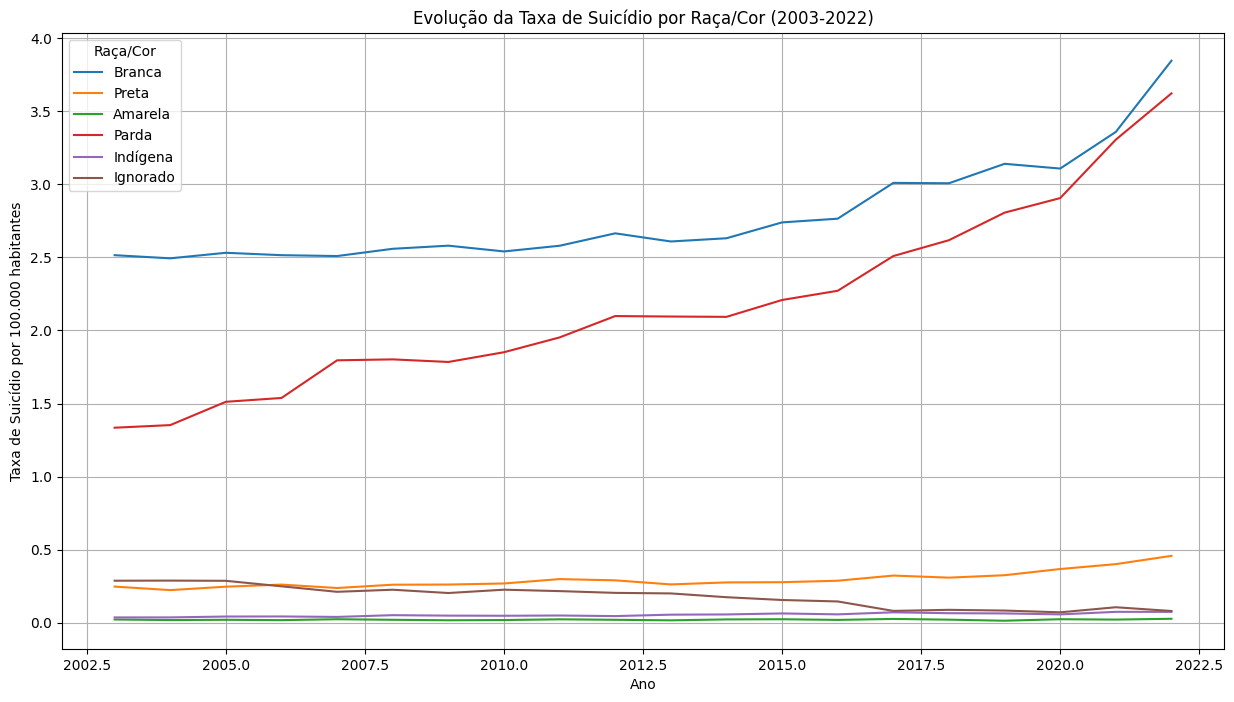

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_grouped = df.groupby(['ano_obito', 'RACACOR'])['RACACOR'].count().unstack()

df_grouped = df_grouped.rename(
    columns={
        1: 'Branca',
        2: 'Preta',
        3: 'Amarela',
        4: 'Parda',
        5: 'Indígena',
        9: 'Ignorado'
    }
)

taxa_suicidio_por_raca_cor = pd.DataFrame()
for raca_cor in df_grouped.columns:
  temp_df = pd.DataFrame({'ano': df_grouped.index, 'RACACOR': raca_cor, 'numero_suicidios': df_grouped[raca_cor]})
  temp_df = pd.merge(temp_df, df_populacao_novo, on='ano', how='left')
  temp_df['taxa_suicidio'] = (temp_df['numero_suicidios'] / temp_df['tam_pop']) * 100000
  taxa_suicidio_por_raca_cor = pd.concat([taxa_suicidio_por_raca_cor, temp_df])


plt.figure(figsize=(15, 8))
for raca_cor in taxa_suicidio_por_raca_cor['RACACOR'].unique():
  subset = taxa_suicidio_por_raca_cor[taxa_suicidio_por_raca_cor['RACACOR'] == raca_cor]
  plt.plot(subset['ano'], subset['taxa_suicidio'], label=raca_cor)

plt.xlabel('Ano')
plt.ylabel('Taxa de Suicídio por 100.000 habitantes')
plt.title('Evolução da Taxa de Suicídio por Raça/Cor (2003-2022)')
plt.grid(True)
plt.legend(title='Raça/Cor', loc='upper left')

plt.savefig('Evolução da Taxa de Suicídio por Raça (2003-2022).png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Evolução da Taxa de Suicídio por Raça (2003-2022).png')


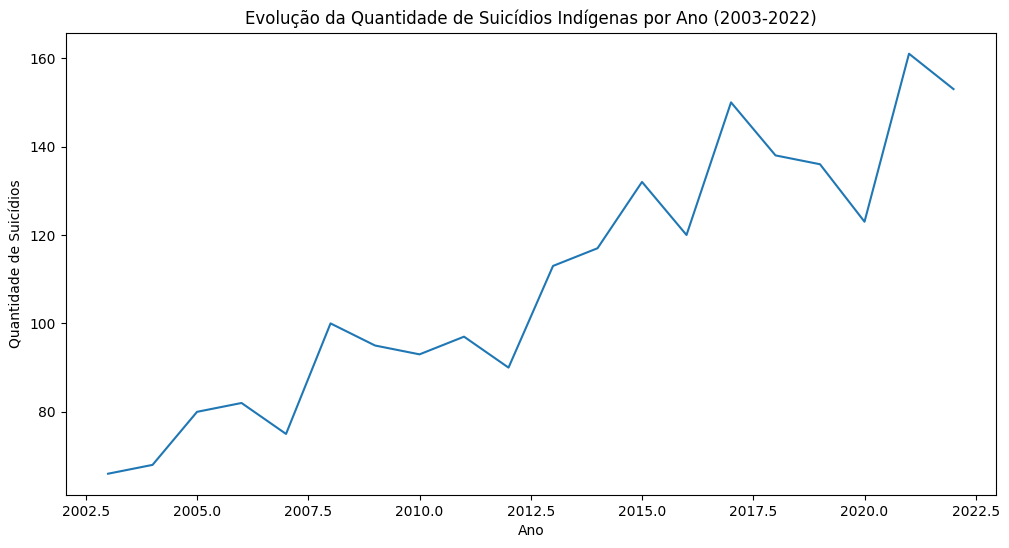

In [ ]:

df_grouped_indigena = df[df['RACACOR'] == 5].groupby('ano_obito')['ano_obito'].count()

plt.figure(figsize=(12, 6))
plt.plot(df_grouped_indigena.index, df_grouped_indigena.values)

plt.title('Evolução da Quantidade de Suicídios Indígenas por Ano (2003-2022)')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Suicídios')

plt.show()


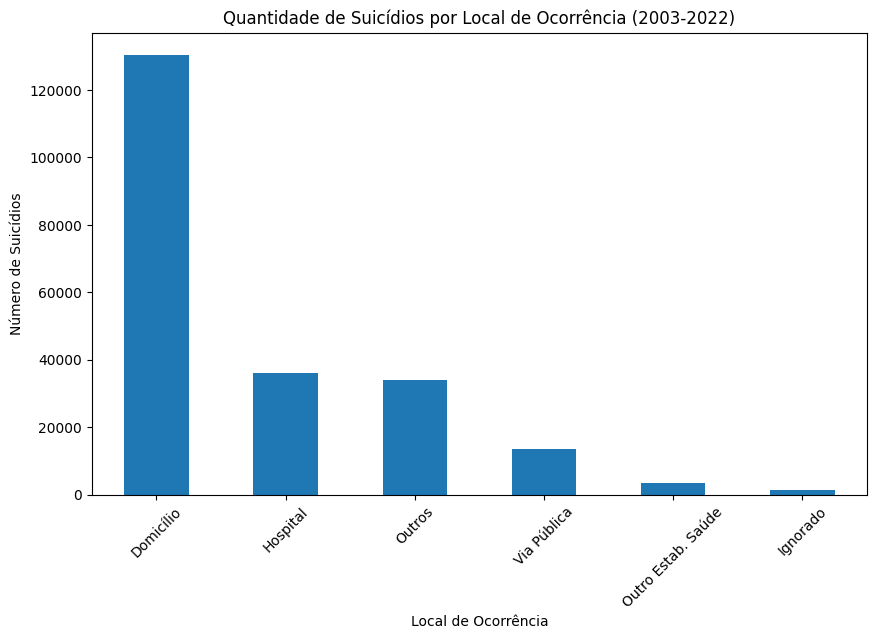

In [ ]:
df_grouped = df['def_loc_ocor'].value_counts()

plt.figure(figsize=(10, 6))
df_grouped.plot(kind='bar')
plt.title('Quantidade de Suicídios por Local de Ocorrência (2003-2022)')
plt.xlabel('Local de Ocorrência')
plt.ylabel('Número de Suicídios')
plt.xticks(rotation=45)
plt.show()


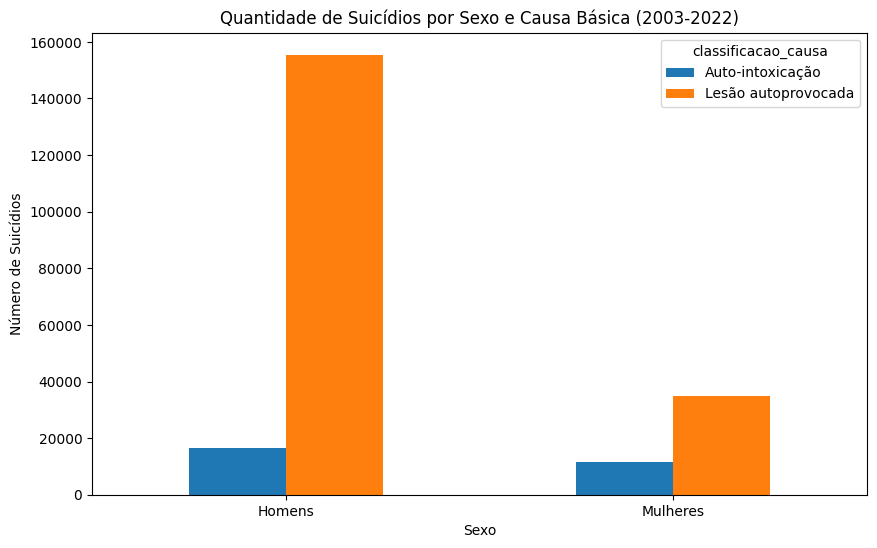

In [ ]:
def classify_cause(causa):
  if str(causa).startswith('X6'):
    return 'Autointoxicação'
  elif str(causa).startswith('X7') or str(causa).startswith('X8'):
    return 'Lesão autoprovocada'
  else:
    return 'Outro'

df['classificacao_causa'] = df['CAUSABAS'].apply(classify_cause)

df_filtered = df[df['classificacao_causa'].isin(['Autointoxicação', 'Lesão autoprovocada'])]

df_filtered = df_filtered[df_filtered['SEXO'].isin([1, 2])]

df_grouped = df_filtered.groupby(['SEXO', 'classificacao_causa'])['SEXO'].count().unstack()

df_grouped = df_grouped.rename(
    columns={
        'Autointoxicação': 'Auto-intoxicação',
        'Lesão autoprovocada': 'Lesão autoprovocada'
    }
)

df_grouped = df_grouped.rename(
    index={
        1: 'Homens',
        2: 'Mulheres'
    }
)

df_grouped.plot(kind='bar', figsize=(10, 6))
plt.title('Quantidade de Suicídios por Sexo e Causa Básica (2003-2022)')
plt.xlabel('Sexo')
plt.ylabel('Número de Suicídios')
plt.xticks(rotation=0)
plt.show()


In [ ]:
def classify_cause(causa):
  if str(causa).startswith('X6'):
    return 'Autointoxicação'
  elif str(causa).startswith('X7') or str(causa).startswith('X8'):
    return 'Lesão autoprovocada'
  else:
    return 'Outro'

df['classificacao_causa'] = df['CAUSABAS'].apply(classify_cause)

df

ano_obito  data_obito CAUSABAS  SEXO  RACACOR  ESC def_loc_ocor  \
0            2022  2022-05-05     X700     1        1    9    Domicílio   
1            2019  2019-10-17     X708     1        4    9       Outros   
2            2019  2019-05-19     X700     1        1    3    Domicílio   
3            2022  2022-04-07     X704     1        4    3  Via Pública   
4            2019  2019-04-23     X680     1        4    3     Hospital   
...           ...         ...      ...   ...      ...  ...          ...   
218702       2010  2010-12-24     X700     1        5    3    Domicílio   
218703       2010  2010-11-21     X699     1        4    3       Outros   
218704       2010  2010-12-29     X700     2        5    3    Domicílio   
218705       2010  2010-12-17     X708     1        5    4    Domicílio   
218706       2010  2010-12-25     X708     1        5    4    Domicílio   

                  res_MUNNOME ocor_SIGLA_UF  idade_obito_anos causa  \
0                Nova Bréscia            RS              60.0   X70   
1                      Coreaú            CE              27.0   X70   
2                     Caucaia            CE              29.0   X70   
3                   Três Rios            RJ              41.0   X70   
4                    Apuiarés            CE              42.0   X68   
...                       ...           ...               ...   ...   
218702      Benjamin Constant            AM              45.0   X70   
218703              Tabatinga            AM              29.0   X69   
218704              Tabatinga            AM              12.0   X70   
218705              Tabatinga            AM              24.0   X70   
218706  São Paulo de Olivença            AM              20.0   X70   

       intervalo_idade  classificacao_causa  
0              50 a 69  Lesão autoprovocada  
1              20 a 29  Lesão autoprovocada  
2              20 a 29  Lesão autoprovocada  
3              30 a 49  Lesão autoprovocada  
4              30 a 49      Autointoxicação  
...                ...                  ...  
218702         30 a 49  Lesão autoprovocada  
218703         20 a 29      Autointoxicação  
218704          5 a 14  Lesão autoprovocada  
218705         20 a 29  Lesão autoprovocada  
218706         20 a 29  Lesão autoprovocada  

[218707 rows x 13 columns]

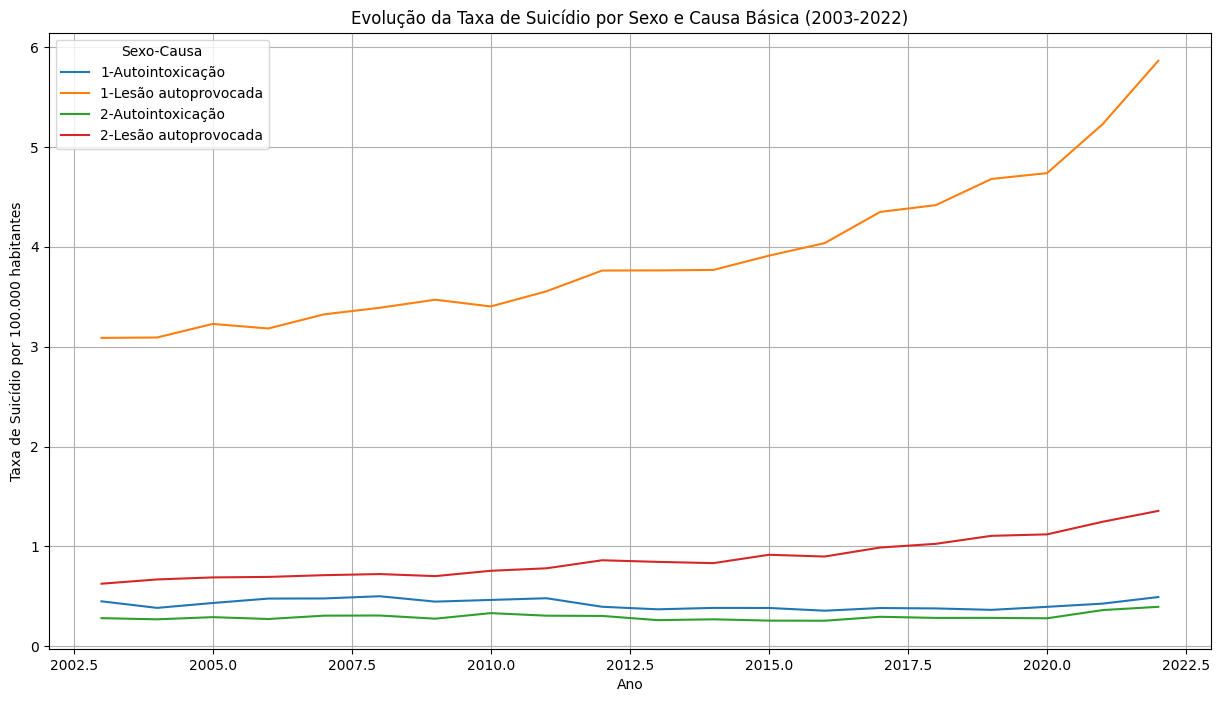

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_filtered = df[df['classificacao_causa'].isin(['Autointoxicação', 'Lesão autoprovocada'])]

df_filtered = df_filtered[df_filtered['SEXO'].isin([1, 2])]

df_grouped = df_filtered.groupby(['ano_obito', 'SEXO', 'classificacao_causa'])['classificacao_causa'].count().unstack([1, 2])

taxa_suicidio_por_sexo_causa = pd.DataFrame()
for sexo in [1, 2]:
  for causa in ['Autointoxicação', 'Lesão autoprovocada']:
    if (sexo, causa) in df_grouped.columns:
      temp_df = pd.DataFrame({'ano': df_grouped.index, 'SEXO': sexo, 'classificacao_causa': causa, 'numero_suicidios': df_grouped[(sexo, causa)]})
      temp_df = pd.merge(temp_df, df_populacao_novo, on='ano', how='left')
      temp_df['taxa_suicidio'] = (temp_df['numero_suicidios'] / temp_df['tam_pop']) * 100000
      taxa_suicidio_por_sexo_causa = pd.concat([taxa_suicidio_por_sexo_causa, temp_df])

plt.figure(figsize=(15, 8))
for sexo in taxa_suicidio_por_sexo_causa['SEXO'].unique():
  for causa in taxa_suicidio_por_sexo_causa['classificacao_causa'].unique():
    subset = taxa_suicidio_por_sexo_causa[(taxa_suicidio_por_sexo_causa['SEXO'] == sexo) & (taxa_suicidio_por_sexo_causa['classificacao_causa'] == causa)]
    if not subset.empty:
      plt.plot(subset['ano'], subset['taxa_suicidio'], label=f"{sexo}-{causa}")

plt.xlabel('Ano')
plt.ylabel('Taxa de Suicídio por 100.000 habitantes')
plt.title('Evolução da Taxa de Suicídio por Sexo e Causa Básica (2003-2022)')
plt.grid(True)
plt.legend(title='Sexo-Causa', loc='upper left')

plt.savefig('Evolução da Taxa de Suicídio por Sexo e Causa Básica (2003-2022).png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Evolução da Taxa de Suicídio por Sexo e Causa Básica (2003-2022).png')


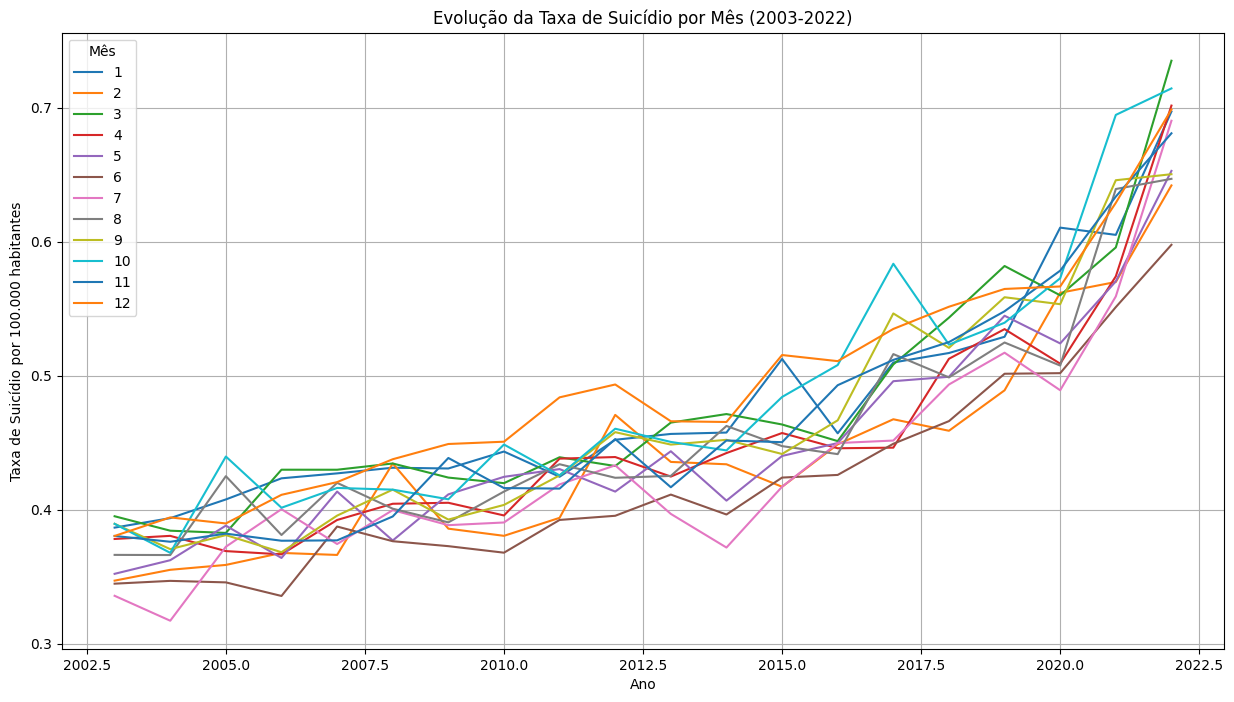

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df['data_obito'] = pd.to_datetime(df['data_obito'], errors='coerce')

df['mes_obito'] = df['data_obito'].dt.month

df_grouped = df.groupby(['ano_obito', 'mes_obito'])['mes_obito'].count().unstack()

taxa_suicidio_por_mes = pd.DataFrame()
for mes in df_grouped.columns:
  temp_df = pd.DataFrame({'ano': df_grouped.index, 'mes_obito': mes, 'numero_suicidios': df_grouped[mes]})
  temp_df = pd.merge(temp_df, df_populacao_novo, on='ano', how='left')
  temp_df['taxa_suicidio'] = (temp_df['numero_suicidios'] / temp_df['tam_pop']) * 100000
  taxa_suicidio_por_mes = pd.concat([taxa_suicidio_por_mes, temp_df])

plt.figure(figsize=(15, 8))
for mes in taxa_suicidio_por_mes['mes_obito'].unique():
  subset = taxa_suicidio_por_mes[taxa_suicidio_por_mes['mes_obito'] == mes]
  plt.plot(subset['ano'], subset['taxa_suicidio'], label=mes)

plt.xlabel('Ano')
plt.ylabel('Taxa de Suicídio por 100.000 habitantes')
plt.title('Evolução da Taxa de Suicídio por Mês (2003-2022)')
plt.grid(True)
plt.legend(title='Mês', loc='upper left')

plt.savefig('Evolução da Taxa de Suicídio por Mês (2003-2022).png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Evolução da Taxa de Suicídio por Mês (2003-2022).png')


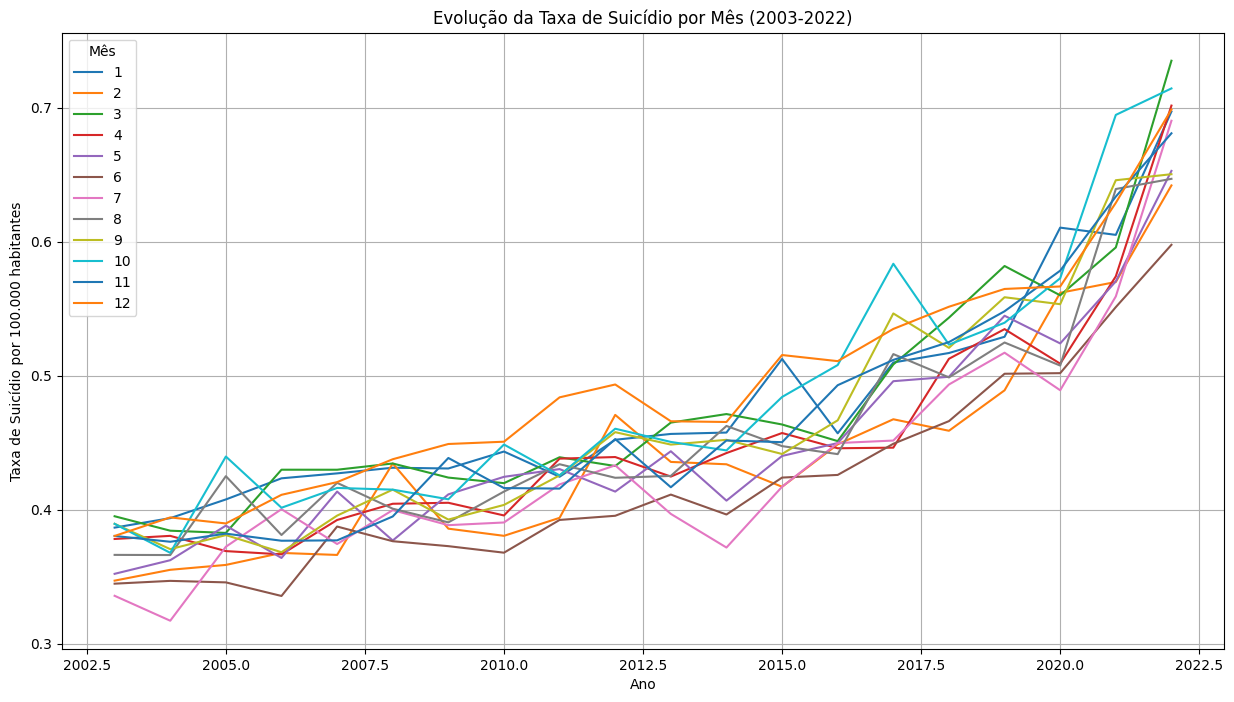

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prompt: taxa de suicidios por 100 mil habitantes ao longo dos anos por mes do ano

import pandas as pd
import matplotlib.pyplot as plt
df_grouped = df.groupby(['ano_obito', 'mes_obito'])['mes_obito'].count().unstack()

taxa_suicidio_por_mes = pd.DataFrame()
for mes in df_grouped.columns:
  temp_df = pd.DataFrame({'ano': df_grouped.index, 'mes_obito': mes, 'numero_suicidios': df_grouped[mes]})
  temp_df = pd.merge(temp_df, df_populacao_novo, on='ano', how='left')
  temp_df['taxa_suicidio'] = (temp_df['numero_suicidios'] / temp_df['tam_pop']) * 100000
  taxa_suicidio_por_mes = pd.concat([taxa_suicidio_por_mes, temp_df])

plt.figure(figsize=(15, 8))
for mes in taxa_suicidio_por_mes['mes_obito'].unique():
  subset = taxa_suicidio_por_mes[taxa_suicidio_por_mes['mes_obito'] == mes]
  plt.plot(subset['ano'], subset['taxa_suicidio'], label=mes)

plt.xlabel('Ano')
plt.ylabel('Taxa de Suicídio por 100.000 habitantes')
plt.title('Evolução da Taxa de Suicídio por Mês (2003-2022)')
plt.grid(True)
plt.legend(title='Mês', loc='upper left')

plt.savefig('Evolução da Taxa de Suicídio por Mês (2003-2022).png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Evolução da Taxa de Suicídio por Mês (2003-2022).png')


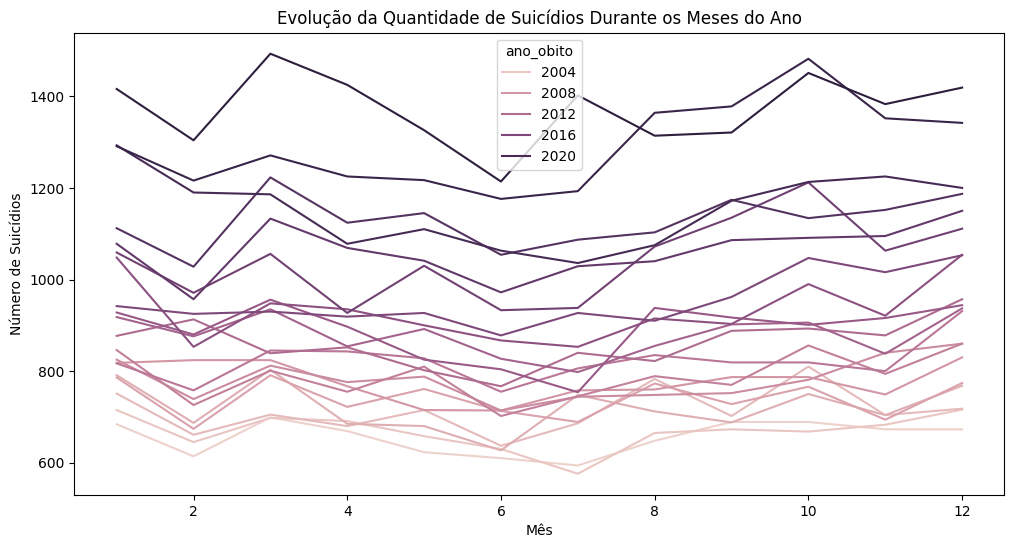

In [ ]:
df_grouped = df.groupby(['ano_obito', 'data_obito'])['data_obito'].count().reset_index(name='count')
df_grouped['month'] = pd.to_datetime(df_grouped['data_obito']).dt.month
df_grouped = df_grouped.groupby(['ano_obito', 'month'])['count'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='count', hue='ano_obito', data=df_grouped)
plt.title('Evolução da Quantidade de Suicídios Durante os Meses do Ano')
plt.xlabel('Mês')
plt.ylabel('Número de Suicídios')
plt.show()


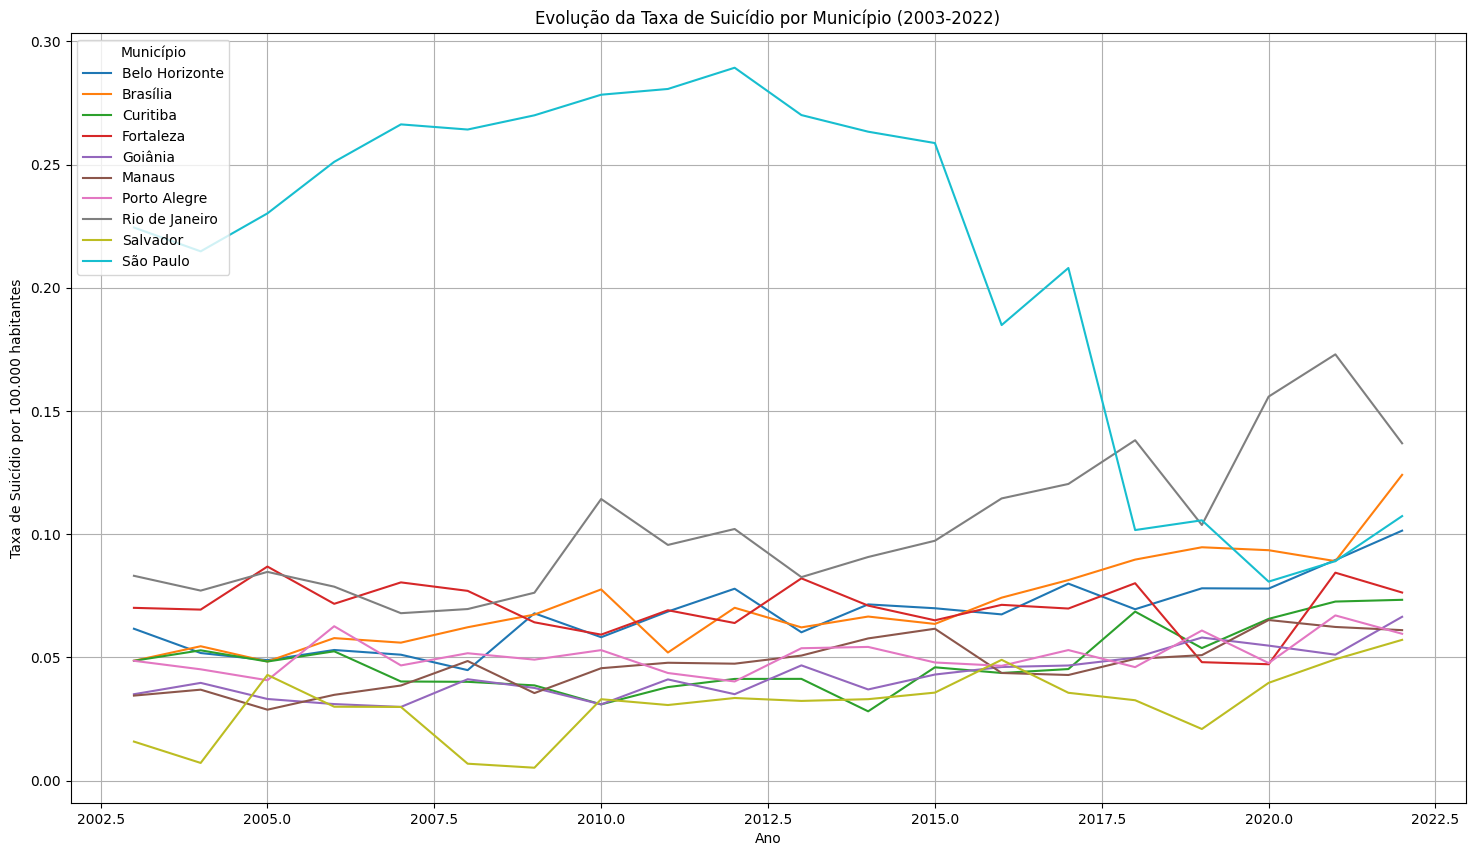

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

df_grouped = df.groupby(['ano_obito', 'res_MUNNOME'])['res_MUNNOME'].count().unstack()

top_10_municipios = df_grouped.sum().sort_values(ascending=False).head(10).index

df_top_10 = df[df['res_MUNNOME'].isin(top_10_municipios)]

df_grouped_top_10 = df_top_10.groupby(['ano_obito', 'res_MUNNOME'])['res_MUNNOME'].count().unstack()


taxa_suicidio_por_municipio = pd.DataFrame()
for municipio in df_grouped_top_10.columns:
  temp_df = pd.DataFrame({'ano': df_grouped_top_10.index, 'res_MUNNOME': municipio, 'numero_suicidios': df_grouped_top_10[municipio]})
  temp_df = pd.merge(temp_df, df_populacao_novo, on='ano', how='left')
  temp_df['taxa_suicidio'] = (temp_df['numero_suicidios'] / temp_df['tam_pop']) * 100000
  taxa_suicidio_por_municipio = pd.concat([taxa_suicidio_por_municipio, temp_df])


plt.figure(figsize=(18, 10))
for municipio in taxa_suicidio_por_municipio['res_MUNNOME'].unique():
  subset = taxa_suicidio_por_municipio[taxa_suicidio_por_municipio['res_MUNNOME'] == municipio]
  plt.plot(subset['ano'], subset['taxa_suicidio'], label=municipio)

plt.xlabel('Ano')
plt.ylabel('Taxa de Suicídio por 100.000 habitantes')
plt.title('Evolução da Taxa de Suicídio por Município (2003-2022)')
plt.grid(True)
plt.legend(title='Município', loc='upper left')

plt.savefig('Evolução da Taxa de Suicídio por Município (2003-2022).png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Evolução da Taxa de Suicídio por Município (2003-2022).png')


In [ ]:
# prompt: novo dataset com o encode de variaveis categoricas do df

from sklearn.preprocessing import LabelEncoder

# Crie uma cópia do DataFrame original para evitar modificá-lo diretamente
df_encoded = df.copy()

# Lista das colunas categóricas que você deseja codificar
categorical_columns = ['SEXO', 'RACACOR', 'ESC', 'CAUSABAS', 'def_loc_ocor', 'ocor_SIGLA_UF', 'res_MUNNOME', 'causa', 'intervalo_idade', 'classificacao_causa']

# Crie um LabelEncoder para cada coluna categórica
label_encoders = {}
for column in categorical_columns:
  le = LabelEncoder()
  df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))
  label_encoders[column] = le

# Exiba o DataFrame com as colunas categóricas codificadas
df_encoded


ano_obito data_obito  CAUSABAS  SEXO  RACACOR  ESC  def_loc_ocor  \
0            2022 2022-05-05        91     1        0    5             0   
1            2019 2019-10-17        99     1        3    5             4   
2            2019 2019-05-19        91     1        0    2             0   
3            2022 2022-04-07        95     1        3    2             5   
4            2019 2019-04-23        71     1        3    2             1   
...           ...        ...       ...   ...      ...  ...           ...   
218702       2010 2010-12-24        91     1        4    2             0   
218703       2010 2010-11-21        90     1        3    2             4   
218704       2010 2010-12-29        91     2        4    2             0   
218705       2010 2010-12-17        99     1        4    3             0   
218706       2010 2010-12-25        99     1        4    3             0   

        res_MUNNOME  ocor_SIGLA_UF  idade_obito_anos  causa  intervalo_idade  \
0              3131             22              60.0     10                4   
1              1264              5              27.0     10                1   
2              1083              5              29.0     10                1   
3              4992             18              41.0     10                2   
4               239              5              42.0      8                2   
...             ...            ...               ...    ...              ...   
218702          539              2              45.0     10                2   
218703         4815              2              29.0      9                1   
218704         4815              2              12.0     10                3   
218705         4815              2              24.0     10                1   
218706         4743              2              20.0     10                1   

        classificacao_causa  mes_obito  
0                         1          5  
1                         1         10  
2                         1          5  
3                         1          4  
4                         0          4  
...                     ...        ...  
218702                    1         12  
218703                    0         11  
218704                    1         12  
218705                    1         12  
218706                    1         12  

[218707 rows x 14 columns]

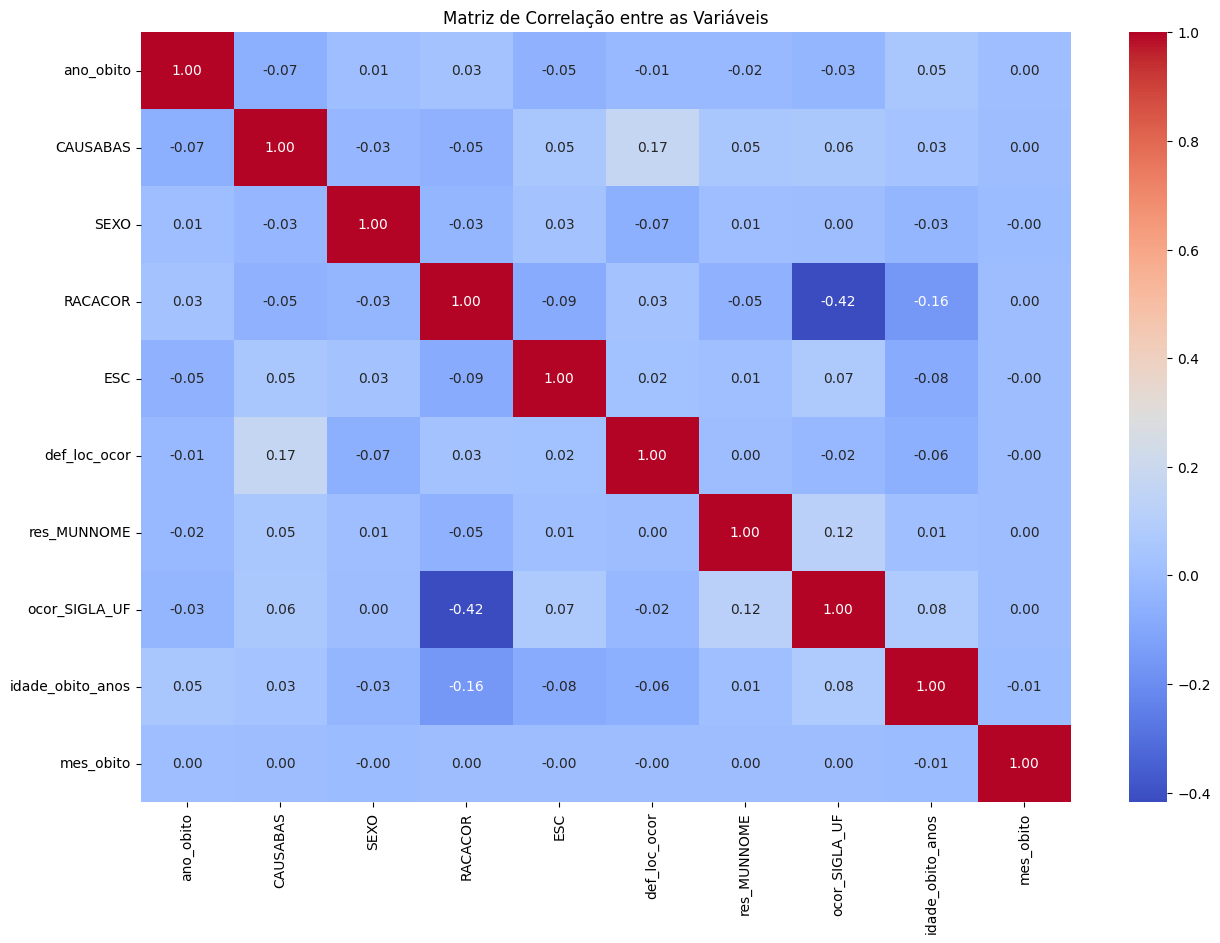

In [ ]:
df_encoded.drop(columns=['data_obito', 'causa', 'classificacao_causa', 'intervalo_idade'], inplace=True)

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre as Variáveis')
plt.show()


#### Prophet Mês

In [ ]:
df_teste = pd.read_csv('sim_limpo_e_alterado.csv')

In [ ]:
df_teste['data_obito'] = pd.to_datetime(df_teste['data_obito'])

df_teste['year-month'] = df_teste['data_obito'].dt.strftime('%Y-%m-01')

df_result = df_teste.groupby('year-month').size().reset_index(name='count')

df_teste.drop(columns=['year-month'], inplace=True)

print(df_result)


     year-month  count
0    2003-01-01    684
1    2003-02-01    614
2    2003-03-01    699
3    2003-04-01    669
4    2003-05-01    623
..          ...    ...
235  2022-08-01   1314
236  2022-09-01   1321
237  2022-10-01   1451
238  2022-11-01   1383
239  2022-12-01   1419

[240 rows x 2 columns]


In [ ]:
df_result.to_csv('suicidios_por_mes.csv', index=False)

In [ ]:
files.download('suicidios_por_mes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_result = pd.read_csv('suicidios_por_mes_1.csv')

In [ ]:
df_result_before_2019 = df_result[pd.to_datetime(df_result['year-month']).dt.year <= 2018]
df_result_after_2018 = df_result[pd.to_datetime(df_result['year-month']).dt.year > 2018]

In [ ]:
df_result_before_2019

year-month  count
0    2003-01-01    684
1    2003-02-01    614
2    2003-03-01    699
3    2003-04-01    669
4    2003-05-01    623
..          ...    ...
187  2018-08-01   1040
188  2018-09-01   1086
189  2018-10-01   1091
190  2018-11-01   1095
191  2018-12-01   1150

[192 rows x 2 columns]

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

df_result['year-month'] = pd.to_datetime(df_result['year-month'])

series = df_result.set_index('year-month')['count']

result = adfuller(series)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
  print("A série temporal é estacionária.")
else:
  print("A série temporal não é estacionária.")


ADF Statistic: 2.704802967212787
p-value: 0.999087257614567
Critical Values: {'1%': np.float64(-3.4594900381360034), '5%': np.float64(-2.8743581895178485), '10%': np.float64(-2.573601605503697)}
A série temporal não é estacionária.


<ipython-input-18-dcd84280e7d1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_before_2019.rename(columns={'year-month': 'ds', 'count': 'y'}, inplace=True)
<ipython-input-18-dcd84280e7d1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_before_2019['ds'] = pd.to_datetime(df_result_before_2019['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk5a5

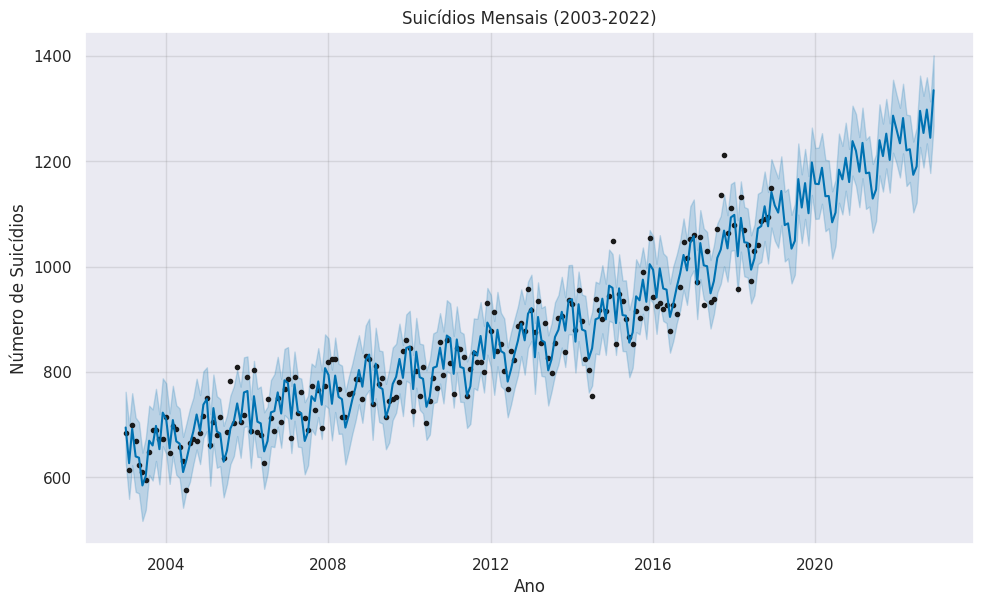

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

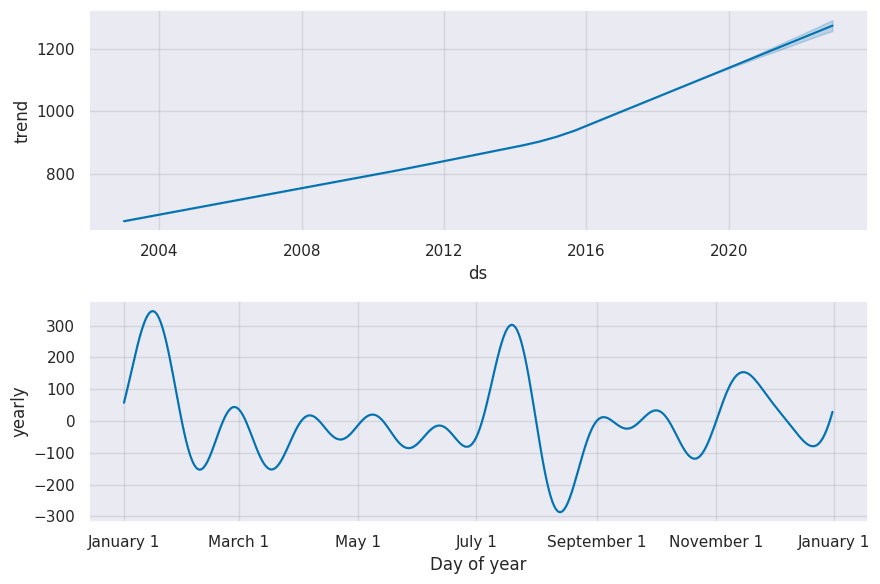

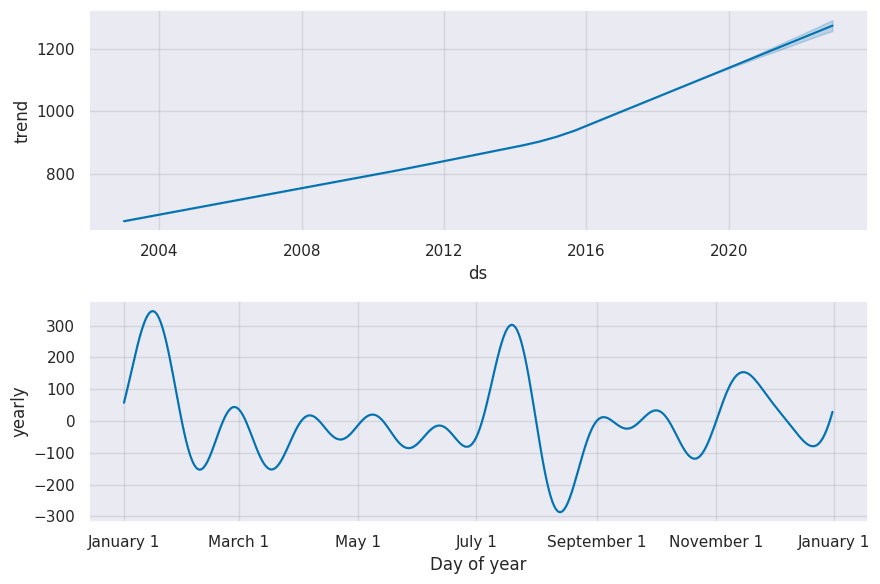

In [ ]:
df_result_before_2019.rename(columns={'year-month': 'ds', 'count': 'y'}, inplace=True)

df_result_before_2019['ds'] = pd.to_datetime(df_result_before_2019['ds'])

model = Prophet(interval_width=0.95)

model.fit(df_result_before_2019)

future = model.make_future_dataframe(periods=48, freq='M')  # Previsão para mais 48 meses (2019-2022)

forecast = model.predict(future)

model.plot(forecast, uncertainty=True)
plt.title('Suicídios Mensais (2003-2022)')
plt.xlabel('Ano')
plt.ylabel('Número de Suicídios')
plt.savefig('Suicídios Mensais (2003-2022) - Prophet.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Suicídios Mensais (2003-2022) - Prophet.png')

model.plot_components(forecast)

# plt.savefig('components_prophet.png', format='png', dpi=300, bbox_inches='tight')
# plt.show()

# files.download('components_prophet.png')

In [ ]:
forecast

ds        trend   yhat_lower   yhat_upper  trend_lower  \
0   2003-01-01   648.613920   629.304251   762.174192   648.613920   
1   2003-02-01   650.406440   558.749962   698.677759   650.406440   
2   2003-03-01   652.025490   622.770951   759.433721   652.025490   
3   2003-04-01   653.818010   572.110159   713.154182   653.818010   
4   2003-05-01   655.552707   569.133141   704.451353   655.552707   
..         ...          ...          ...          ...          ...   
235 2022-07-31  1258.735740  1227.149855  1362.652457  1244.110312   
236 2022-08-31  1262.669516  1188.090576  1324.153374  1247.547549   
237 2022-09-30  1266.476396  1233.873685  1359.362429  1250.843932   
238 2022-10-31  1270.410171  1177.596845  1313.649200  1253.866216   
239 2022-11-30  1274.217051  1266.879841  1401.198378  1257.038196   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     648.613920       45.743251             45.743251             45.743251   
1     650.406440      -23.850108            -23.850108            -23.850108   
2     652.025490       39.720484             39.720484             39.720484   
3     653.818010      -14.404416            -14.404416            -14.404416   
4     655.552707      -18.602308            -18.602308            -18.602308   
..           ...             ...                   ...                   ...   
235  1274.478004       36.947505             36.947505             36.947505   
236  1278.998432       -9.029886             -9.029886             -9.029886   
237  1283.378698       31.663208             31.663208             31.663208   
238  1287.621364      -25.899513            -25.899513            -25.899513   
239  1292.087840       60.634904             60.634904             60.634904   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0    45.743251     45.743251     45.743251                   0.0   
1   -23.850108    -23.850108    -23.850108                   0.0   
2    39.720484     39.720484     39.720484                   0.0   
3   -14.404416    -14.404416    -14.404416                   0.0   
4   -18.602308    -18.602308    -18.602308                   0.0   
..         ...           ...           ...                   ...   
235  36.947505     36.947505     36.947505                   0.0   
236  -9.029886     -9.029886     -9.029886                   0.0   
237  31.663208     31.663208     31.663208                   0.0   
238 -25.899513    -25.899513    -25.899513                   0.0   
239  60.634904     60.634904     60.634904                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                           0.0                         0.0   694.357171  
1                           0.0                         0.0   626.556331  
2                           0.0                         0.0   691.745975  
3                           0.0                         0.0   639.413594  
4                           0.0                         0.0   636.950399  
..                          ...                         ...          ...  
235                         0.0                         0.0  1295.683245  
236                         0.0                         0.0  1253.639630  
237                         0.0                         0.0  1298.139604  
238                         0.0                         0.0  1244.510658  
239                         0.0                         0.0  1334.851956  

[240 rows x 16 columns]

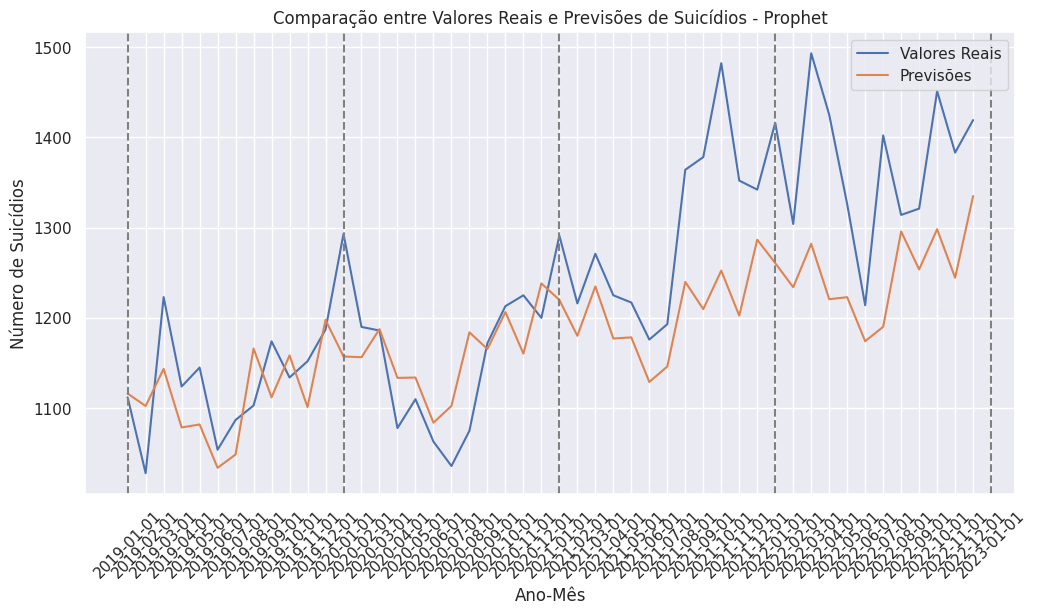

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
forecast_values = forecast['yhat'][-48:]

df_compare = df_result_after_2018.copy()

df_compare['forecast'] = forecast_values.values

plt.figure(figsize=(12, 6))
plt.plot(df_compare['year-month'], df_compare['count'], label='Valores Reais')
plt.plot(df_compare['year-month'], df_compare['forecast'], label='Previsões')

for i in range(2019, 2024):
  plt.axvline(x=f'{i}-01-01', color='gray', linestyle='--')

plt.xlabel('Ano-Mês')
plt.ylabel('Número de Suicídios')
plt.title('Comparação entre Valores Reais e Previsões de Suicídios - Prophet')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('Comparação entre Valores Reais e Previsões de Suicídios - Prophet.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Comparação entre Valores Reais e Previsões de Suicídios - Prophet.png')


In [ ]:
df_compare_2020_2022 = df_compare[pd.to_datetime(df_compare['year-month']).dt.year.isin([2020, 2021, 2022])]

In [ ]:
df_compare_2019 = df_compare[pd.to_datetime(df_compare['year-month']).dt.year == 2019]

In [ ]:
y_true = df_compare_2019['count'].values
y_pred = df_compare_2019['forecast'].values

# Calculando o MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculando o MSE
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculando o RMSE (Raiz do Erro Quadrático Médio)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculando o MAPE (Erro Percentual Absoluto Médio)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')


Mean Absolute Error (MAE): 44.63629094856068
Mean Squared Error (MSE): 2571.2668469783466
Root Mean Squared Error (RMSE): 50.707660634053575
Mean Absolute Percentage Error (MAPE): 3.960711347130683%


Modelo bom, previu 2019 corretamente, o que significa que poderia prever bem para 2020 e 2021, mas os números reais foram exarcebados

In [ ]:
y_true = df_compare_2020_2022['count'].values

# y_pred são as previsões geradas pelo Prophet
y_pred = df_compare_2020_2022['forecast'].values


# Calculando o MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculando o MSE
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculando o RMSE (Raiz do Erro Quadrático Médio)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculando o MAPE (Erro Percentual Absoluto Médio)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Absolute Error (MAE): 85.27041173665157
Mean Squared Error (MSE): 11398.41242477256
Root Mean Squared Error (RMSE): 106.76334775929686
Mean Absolute Percentage Error (MAPE): 6.419183924361832%


In [ ]:
df_compare_2020_2022

year-month  count     forecast
204  2020-01-01   1293  1157.253706
205  2020-02-01   1190  1156.450541
206  2020-03-01   1186  1187.566286
207  2020-04-01   1078  1133.569740
208  2020-05-01   1110  1133.969206
209  2020-06-01   1063  1083.979564
210  2020-07-01   1036  1102.476383
211  2020-08-01   1075  1184.015357
212  2020-09-01   1172  1165.532022
213  2020-10-01   1213  1206.462014
214  2020-11-01   1225  1160.405449
215  2020-12-01   1200  1238.208012
216  2021-01-01   1291  1219.900044
217  2021-02-01   1216  1180.162619
218  2021-03-01   1271  1234.874895
219  2021-04-01   1225  1177.157605
220  2021-05-01   1217  1178.434335
221  2021-06-01   1176  1129.054659
222  2021-07-01   1193  1146.196598
223  2021-08-01   1364  1239.858194
224  2021-09-01   1378  1209.656717
225  2021-10-01   1482  1252.342282
226  2021-11-01   1352  1202.438650
227  2021-12-01   1342  1286.525421
228  2022-01-01   1416  1260.700580
229  2022-02-01   1304  1233.946572
230  2022-03-01   1493  1282.013719
231  2022-04-01   1425  1220.666325
232  2022-05-01   1326  1222.907396
233  2022-06-01   1214  1174.192986
234  2022-07-01   1402  1190.091303
235  2022-08-01   1314  1295.683245
236  2022-09-01   1321  1253.639630
237  2022-10-01   1451  1298.139604
238  2022-11-01   1383  1244.510658
239  2022-12-01   1419  1334.851956

In [ ]:
from scipy.stats import shapiro
from scipy import stats

df_compare_2019['residuos'] = df_compare_2019['count'] - df_compare_2019['forecast']

t_stat, p_value = stats.ttest_1samp(df_compare_2019['residuos'], 0)

print(f'Estatística t: {t_stat}')
print(f'Valor p: {p_value}')

alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula. As previsões são significativamente diferentes dos valores observados.")
else:
    print("Falha em rejeitar a hipótese nula. As previsões não são significativamente diferentes dos valores observados.")


stat, p_value = shapiro(df_compare_2019['residuos'])

print(f'Estatística: {stat}, Valor p: {p_value}')

if p_value > 0.05:
    print("Os resíduos seguem uma distribuição normal (não rejeitamos a hipótese nula).")
else:
    print("Os resíduos não seguem uma distribuição normal (rejeitamos a hipótese nula).")


Estatística t: 1.0372045189098031
Valor p: 0.3219036257917116
Falha em rejeitar a hipótese nula. As previsões não são significativamente diferentes dos valores observados.
Estatística: 0.9260477446485377, Valor p: 0.3400949097239303
Os resíduos seguem uma distribuição normal (não rejeitamos a hipótese nula).


<ipython-input-26-e4db174515f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compare_2019['residuos'] = df_compare_2019['count'] - df_compare_2019['forecast']


#### Modelo Comparativo ao Prophet (SARIMA e LSTM):


In [ ]:
df_result = pd.read_csv('suicidios_por_mes_1.csv')

In [ ]:
df_result

year-month  count
0    2003-01-01    684
1    2003-02-01    614
2    2003-03-01    699
3    2003-04-01    669
4    2003-05-01    623
..          ...    ...
235  2022-08-01   1314
236  2022-09-01   1321
237  2022-10-01   1451
238  2022-11-01   1383
239  2022-12-01   1419

[240 rows x 2 columns]

In [ ]:
df_result_before_2019 = df_result[pd.to_datetime(df_result['year-month']).dt.year <= 2018]
df_result_after_2018 = df_result[pd.to_datetime(df_result['year-month']).dt.year > 2018]

In [ ]:
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(df_result_before_2019['count'],
                                         order=(1, 1, 1),      # Parâmetros ARIMA (p, d, q)
                                         seasonal_order=(1, 1, 1, 12),  # Parâmetros sazonais (P, D, Q, sazonalidade anual m=12)
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)

print(sarima_result.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              count   No. Observations:                  192
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -847.717
Date:                            Tue, 06 May 2025   AIC                           1705.433
Time:                                    04:55:26   BIC                           1720.963
Sample:                                         0   HQIC                          1711.737
                                            - 192                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0221      0.092      0.239      0.811      -0.159       0.203
ma.L1         -0.8604      0.048   

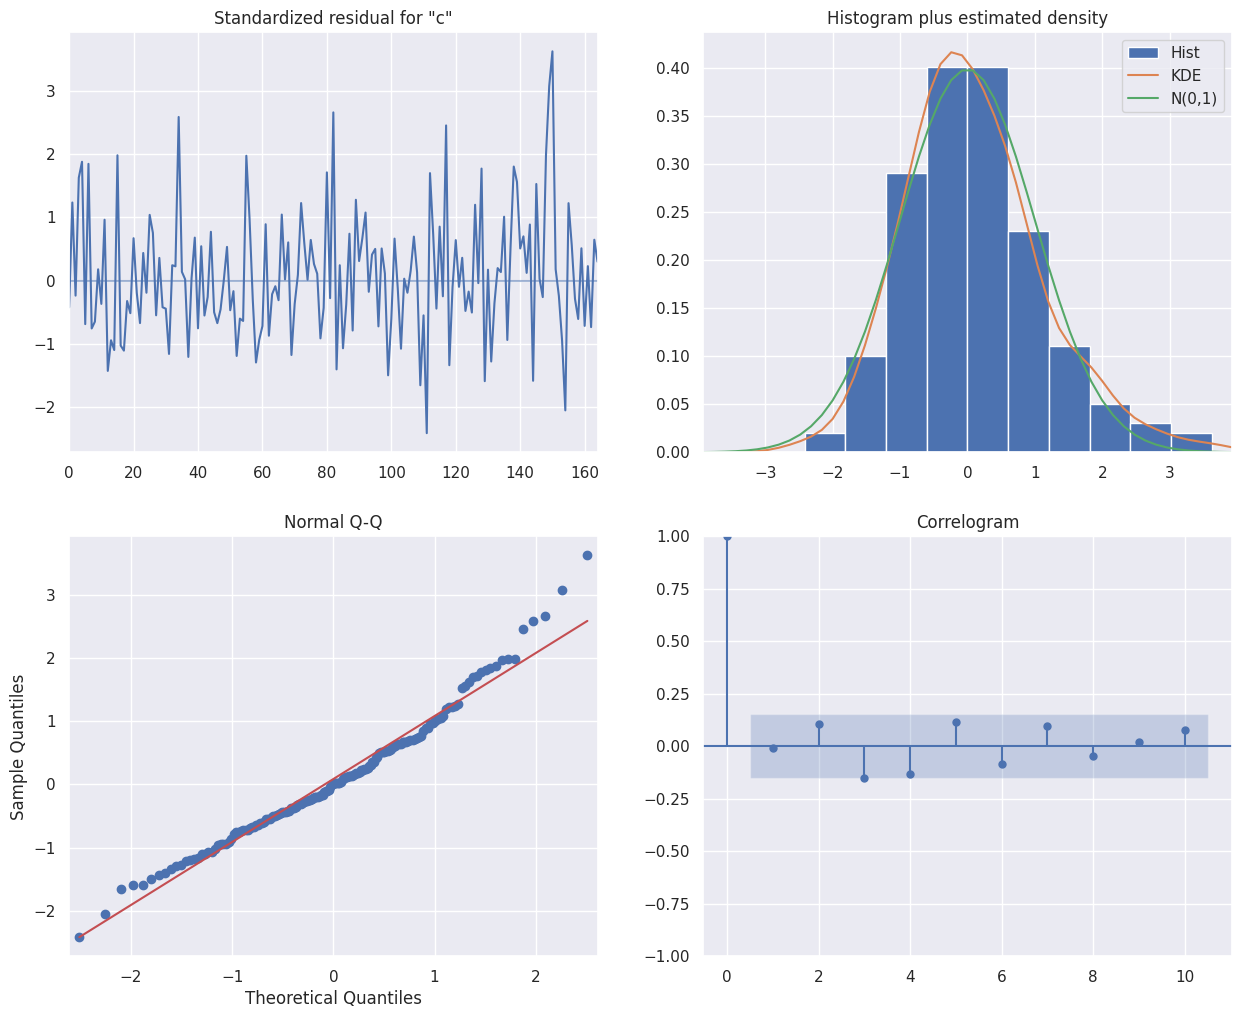

In [ ]:
sarima_result.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
adf_result = adfuller(sarima_result.resid)

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

if adf_result[1] <= 0.05:
  print("A série temporal de resíduos é estacionária.")
else:
  print("A série temporal de resíduos não é estacionária.")


ADF Statistic: -7.1163447233759
p-value: 3.822134175643083e-10
Critical Values: {'1%': np.float64(-3.465811691080702), '5%': np.float64(-2.877123351472649), '10%': np.float64(-2.5750770662586864)}
A série temporal de resíduos é estacionária.


In [ ]:
forecast_sarima = sarima_result.get_forecast(steps=48)

forecast_ci = forecast_sarima.conf_int()

print(forecast_sarima.predicted_mean)


192    1133.201624
193    1055.997111
194    1127.657022
195    1078.588360
196    1078.240800
197    1022.427447
198    1043.296425
199    1094.417177
200    1111.652889
201    1148.958537
202    1108.359822
203    1171.414807
204    1163.747278
205    1086.644476
206    1158.550110
207    1109.447027
208    1109.035537
209    1053.191698
210    1074.144209
211    1125.172204
212    1142.474417
213    1179.705376
214    1139.209772
215    1202.246134
216    1194.557495
217    1117.454458
218    1189.359523
219    1140.256520
220    1139.845178
221    1084.001409
222    1104.953727
223    1155.981937
224    1173.283996
225    1210.515128
226    1170.019285
227    1233.055690
228    1225.367100
229    1148.264064
230    1220.169130
231    1171.066126
232    1170.654784
233    1114.811015
234    1135.763334
235    1186.791543
236    1204.093603
237    1241.324734
238    1200.828892
239    1263.865297
Name: predicted_mean, dtype: float64


In [ ]:

df_compare['forecast_sarima'] = forecast_sarima.predicted_mean.values


In [ ]:
df_compare

year-month  count     forecast  forecast_sarima
192  2019-01-01   1112  1116.220503      1133.201624
193  2019-02-01   1028  1102.448615      1055.997111
194  2019-03-01   1223  1143.585873      1127.657022
195  2019-04-01   1124  1078.704859      1078.588360
196  2019-05-01   1145  1081.997440      1078.240800
197  2019-06-01   1054  1034.002485      1022.427447
198  2019-07-01   1087  1048.765030      1043.296425
199  2019-08-01   1103  1166.085041      1094.417177
200  2019-09-01   1174  1112.085702      1111.652889
201  2019-10-01   1134  1158.461503      1148.958537
202  2019-11-01   1152  1101.231342      1108.359822
203  2019-12-01   1187  1197.792561      1171.414807
204  2020-01-01   1293  1157.253706      1163.747278
205  2020-02-01   1190  1156.450541      1086.644476
206  2020-03-01   1186  1187.566286      1158.550110
207  2020-04-01   1078  1133.569740      1109.447027
208  2020-05-01   1110  1133.969206      1109.035537
209  2020-06-01   1063  1083.979564      1053.191698
210  2020-07-01   1036  1102.476383      1074.144209
211  2020-08-01   1075  1184.015357      1125.172204
212  2020-09-01   1172  1165.532022      1142.474417
213  2020-10-01   1213  1206.462014      1179.705376
214  2020-11-01   1225  1160.405449      1139.209772
215  2020-12-01   1200  1238.208012      1202.246134
216  2021-01-01   1291  1219.900044      1194.557495
217  2021-02-01   1216  1180.162619      1117.454458
218  2021-03-01   1271  1234.874895      1189.359523
219  2021-04-01   1225  1177.157605      1140.256520
220  2021-05-01   1217  1178.434335      1139.845178
221  2021-06-01   1176  1129.054659      1084.001409
222  2021-07-01   1193  1146.196598      1104.953727
223  2021-08-01   1364  1239.858194      1155.981937
224  2021-09-01   1378  1209.656717      1173.283996
225  2021-10-01   1482  1252.342282      1210.515128
226  2021-11-01   1352  1202.438650      1170.019285
227  2021-12-01   1342  1286.525421      1233.055690
228  2022-01-01   1416  1260.700580      1225.367100
229  2022-02-01   1304  1233.946572      1148.264064
230  2022-03-01   1493  1282.013719      1220.169130
231  2022-04-01   1425  1220.666325      1171.066126
232  2022-05-01   1326  1222.907396      1170.654784
233  2022-06-01   1214  1174.192986      1114.811015
234  2022-07-01   1402  1190.091303      1135.763334
235  2022-08-01   1314  1295.683245      1186.791543
236  2022-09-01   1321  1253.639630      1204.093603
237  2022-10-01   1451  1298.139604      1241.324734
238  2022-11-01   1383  1244.510658      1200.828892
239  2022-12-01   1419  1334.851956      1263.865297

In [ ]:

df_compare_2019 = df_compare[pd.to_datetime(df_compare['year-month']).dt.year == 2019]


In [ ]:
y_true = df_compare_2019['count'].values
y_pred = df_compare_2019['forecast_sarima'].values

# Calculando o MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculando o MSE
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculando o RMSE (Raiz do Erro Quadrático Médio)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculando o MAPE (Erro Percentual Absoluto Médio)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')


Mean Absolute Error (MAE): 39.75854362106231
Mean Squared Error (MSE): 2173.4512824368644
Root Mean Squared Error (RMSE): 46.62028831353217
Mean Absolute Percentage Error (MAPE): 3.485144621895633%


In [ ]:
from scipy.stats import shapiro
from scipy import stats

df_compare_2019['residuos_sarima'] = df_compare_2019['count'] - df_compare_2019['forecast_sarima']

t_stat, p_value = stats.ttest_1samp(df_compare_2019['residuos_sarima'], 0)

print(f'Estatística t: {t_stat}')
print(f'Valor p: {p_value}')

alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula. As previsões são significativamente diferentes dos valores observados.")
else:
    print("Falha em rejeitar a hipótese nula. As previsões não são significativamente diferentes dos valores observados.")


stat, p_value = shapiro(df_compare_2019['residuos_sarima'])

print(f'Estatística: {stat}, Valor p: {p_value}')

if p_value > 0.05:
    print("Os resíduos seguem uma distribuição normal (não rejeitamos a hipótese nula).")
else:
    print("Os resíduos não seguem uma distribuição normal (rejeitamos a hipótese nula).")


Estatística t: 2.6446804468624516
Valor p: 0.022801897175000387
Rejeitamos a hipótese nula. As previsões são significativamente diferentes dos valores observados.
Estatística: 0.9600661216222458, Valor p: 0.784773574752009
Os resíduos seguem uma distribuição normal (não rejeitamos a hipótese nula).


<ipython-input-38-904a9252a58b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compare_2019['residuos_sarima'] = df_compare_2019['count'] - df_compare_2019['forecast_sarima']


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

scaler = MinMaxScaler(feature_range=(0, 1))
df_result_before_2019['scaled_count'] = scaler.fit_transform(df_result_before_2019[['count']])

def create_sequences(data, time_steps=12):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        seq = data[i:i+time_steps]
        label = data[i+time_steps]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

time_steps = 12  # Usar os últimos 12 meses para prever o próximo mês
X, y = create_sequences(df_result_before_2019['scaled_count'].values, time_steps)


X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, epochs=100, batch_size=32, callbacks=[early_stopping])


<ipython-input-39-5f5fe4fe3027>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_before_2019['scaled_count'] = scaler.fit_transform(df_result_before_2019[['count']])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1995
Epoch 2/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0959

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0854 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0180 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0136
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0098 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0104 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0084 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0088 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0075
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0075
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080
Epoch 16/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 
Epoch 17/100
6/6 ━━━━━━━━━━━━

In [ ]:
def predict_future(model, data, steps, time_steps=12):
    predictions = []
    current_sequence = data[-time_steps:]
    for _ in range(steps):
        pred = model.predict(current_sequence.reshape((1, time_steps, 1)))
        predictions.append(pred[0][0])
        current_sequence = np.append(current_sequence[1:], pred)[-time_steps:]
    return np.array(predictions)

predictions_lstm = predict_future(model, df_result_before_2019['scaled_count'].values, steps=48)

predictions_lstm_rescaled = scaler.inverse_transform(predictions_lstm.reshape(-1, 1))

print(predictions_lstm_rescaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

In [ ]:

forecast_lstm_array = predictions_lstm_rescaled.flatten().tolist()


In [ ]:
df_compare['forecast_lstm'] = forecast_lstm_array

In [ ]:
df_compare

year-month  count     forecast  forecast_sarima  forecast_lstm
192  2019-01-01   1112  1116.220503      1133.201624    1098.740356
193  2019-02-01   1028  1102.448615      1055.997111    1096.736572
194  2019-03-01   1223  1143.585873      1127.657022    1109.021606
195  2019-04-01   1124  1078.704859      1078.588360    1105.034546
196  2019-05-01   1145  1081.997440      1078.240800    1106.706909
197  2019-06-01   1054  1034.002485      1022.427447    1111.741699
198  2019-07-01   1087  1048.765030      1043.296425    1124.355347
199  2019-08-01   1103  1166.085041      1094.417177    1132.723999
200  2019-09-01   1174  1112.085702      1111.652889    1140.570801
201  2019-10-01   1134  1158.461503      1148.958537    1144.631226
202  2019-11-01   1152  1101.231342      1108.359822    1148.396484
203  2019-12-01   1187  1197.792561      1171.414807    1152.086792
204  2020-01-01   1293  1157.253706      1163.747278    1150.877808
205  2020-02-01   1190  1156.450541      1086.644476    1154.235474
206  2020-03-01   1186  1187.566286      1158.550110    1158.321777
207  2020-04-01   1078  1133.569740      1109.447027    1161.703491
208  2020-05-01   1110  1133.969206      1109.035537    1165.765259
209  2020-06-01   1063  1083.979564      1053.191698    1170.094727
210  2020-07-01   1036  1102.476383      1074.144209    1174.381958
211  2020-08-01   1075  1184.015357      1125.172204    1177.918213
212  2020-09-01   1172  1165.532022      1142.474417    1180.989624
213  2020-10-01   1213  1206.462014      1179.705376    1183.617920
214  2020-11-01   1225  1160.405449      1139.209772    1186.107544
215  2020-12-01   1200  1238.208012      1202.246134    1188.491943
216  2021-01-01   1291  1219.900044      1194.557495    1190.775269
217  2021-02-01   1216  1180.162619      1117.454458    1193.382080
218  2021-03-01   1271  1234.874895      1189.359523    1195.963257
219  2021-04-01   1225  1177.157605      1140.256520    1198.436768
220  2021-05-01   1217  1178.434335      1139.845178    1200.849487
221  2021-06-01   1176  1129.054659      1084.001409    1203.139526
222  2021-07-01   1193  1146.196598      1104.953727    1205.269653
223  2021-08-01   1364  1239.858194      1155.981937    1207.228027
224  2021-09-01   1378  1209.656717      1173.283996    1209.063110
225  2021-10-01   1482  1252.342282      1210.515128    1210.807129
226  2021-11-01   1352  1202.438650      1170.019285    1212.492065
227  2021-12-01   1342  1286.525421      1233.055690    1214.126709
228  2022-01-01   1416  1260.700580      1225.367100    1215.717407
229  2022-02-01   1304  1233.946572      1148.264064    1217.269043
230  2022-03-01   1493  1282.013719      1220.169130    1218.752075
231  2022-04-01   1425  1220.666325      1171.066126    1220.161377
232  2022-05-01   1326  1222.907396      1170.654784    1221.498413
233  2022-06-01   1214  1174.192986      1114.811015    1222.762207
234  2022-07-01   1402  1190.091303      1135.763334    1223.956055
235  2022-08-01   1314  1295.683245      1186.791543    1225.087402
236  2022-09-01   1321  1253.639630      1204.093603    1226.165039
237  2022-10-01   1451  1298.139604      1241.324734    1227.194946
238  2022-11-01   1383  1244.510658      1200.828892    1228.180786
239  2022-12-01   1419  1334.851956      1263.865297    1229.123657

In [ ]:
df_compare_2019 = df_compare[pd.to_datetime(df_compare['year-month']).dt.year == 2019]

In [ ]:
df_compare_2019

year-month  count     forecast  forecast_sarima  forecast_lstm
192  2019-01-01   1112  1116.220503      1133.201624    1098.740356
193  2019-02-01   1028  1102.448615      1055.997111    1096.736572
194  2019-03-01   1223  1143.585873      1127.657022    1109.021606
195  2019-04-01   1124  1078.704859      1078.588360    1105.034546
196  2019-05-01   1145  1081.997440      1078.240800    1106.706909
197  2019-06-01   1054  1034.002485      1022.427447    1111.741699
198  2019-07-01   1087  1048.765030      1043.296425    1124.355347
199  2019-08-01   1103  1166.085041      1094.417177    1132.723999
200  2019-09-01   1174  1112.085702      1111.652889    1140.570801
201  2019-10-01   1134  1158.461503      1148.958537    1144.631226
202  2019-11-01   1152  1101.231342      1108.359822    1148.396484
203  2019-12-01   1187  1197.792561      1171.414807    1152.086792

In [ ]:
y_true = df_compare_2019['count'].values
y_pred = df_compare_2019['forecast_lstm'].values

# Calculando o MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculando o MSE
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculando o RMSE (Raiz do Erro Quadrático Médio)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculando o MAPE (Erro Percentual Absoluto Médio)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')


Mean Absolute Error (MAE): 38.385945638020836
Mean Squared Error (MSE): 2316.095964456598
Root Mean Squared Error (RMSE): 48.12583468841447
Mean Absolute Percentage Error (MAPE): 3.4065755738202377%


In [ ]:
from scipy.stats import shapiro
from scipy import stats

df_compare_2019['residuos_lstm'] = df_compare_2019['count'] - df_compare_2019['forecast_lstm']

t_stat, p_value = stats.ttest_1samp(df_compare_2019['residuos_lstm'], 0)

print(f'Estatística t: {t_stat}')
print(f'Valor p: {p_value}')

alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula. As previsões são significativamente diferentes dos valores observados.")
else:
    print("Falha em rejeitar a hipótese nula. As previsões não são significativamente diferentes dos valores observados.")


stat, p_value = shapiro(df_compare_2019['residuos_lstm'])

print(f'Estatística: {stat}, Valor p: {p_value}')

if p_value > 0.05:
    print("Os resíduos seguem uma distribuição normal (não rejeitamos a hipótese nula).")
else:
    print("Os resíduos não seguem uma distribuição normal (rejeitamos a hipótese nula).")


Estatística t: 0.3013273923303376
Valor p: 0.7687846331998798
Falha em rejeitar a hipótese nula. As previsões não são significativamente diferentes dos valores observados.
Estatística: 0.9517515481449117, Valor p: 0.6627173515992725
Os resíduos seguem uma distribuição normal (não rejeitamos a hipótese nula).


<ipython-input-47-b17dd5c81eb6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compare_2019['residuos_lstm'] = df_compare_2019['count'] - df_compare_2019['forecast_lstm']


In [ ]:
df_compare

year-month  count     forecast  forecast_sarima  forecast_lstm
192  2019-01-01   1112  1116.220503      1133.201624    1098.740356
193  2019-02-01   1028  1102.448615      1055.997111    1096.736572
194  2019-03-01   1223  1143.585873      1127.657022    1109.021606
195  2019-04-01   1124  1078.704859      1078.588360    1105.034546
196  2019-05-01   1145  1081.997440      1078.240800    1106.706909
197  2019-06-01   1054  1034.002485      1022.427447    1111.741699
198  2019-07-01   1087  1048.765030      1043.296425    1124.355347
199  2019-08-01   1103  1166.085041      1094.417177    1132.723999
200  2019-09-01   1174  1112.085702      1111.652889    1140.570801
201  2019-10-01   1134  1158.461503      1148.958537    1144.631226
202  2019-11-01   1152  1101.231342      1108.359822    1148.396484
203  2019-12-01   1187  1197.792561      1171.414807    1152.086792
204  2020-01-01   1293  1157.253706      1163.747278    1150.877808
205  2020-02-01   1190  1156.450541      1086.644476    1154.235474
206  2020-03-01   1186  1187.566286      1158.550110    1158.321777
207  2020-04-01   1078  1133.569740      1109.447027    1161.703491
208  2020-05-01   1110  1133.969206      1109.035537    1165.765259
209  2020-06-01   1063  1083.979564      1053.191698    1170.094727
210  2020-07-01   1036  1102.476383      1074.144209    1174.381958
211  2020-08-01   1075  1184.015357      1125.172204    1177.918213
212  2020-09-01   1172  1165.532022      1142.474417    1180.989624
213  2020-10-01   1213  1206.462014      1179.705376    1183.617920
214  2020-11-01   1225  1160.405449      1139.209772    1186.107544
215  2020-12-01   1200  1238.208012      1202.246134    1188.491943
216  2021-01-01   1291  1219.900044      1194.557495    1190.775269
217  2021-02-01   1216  1180.162619      1117.454458    1193.382080
218  2021-03-01   1271  1234.874895      1189.359523    1195.963257
219  2021-04-01   1225  1177.157605      1140.256520    1198.436768
220  2021-05-01   1217  1178.434335      1139.845178    1200.849487
221  2021-06-01   1176  1129.054659      1084.001409    1203.139526
222  2021-07-01   1193  1146.196598      1104.953727    1205.269653
223  2021-08-01   1364  1239.858194      1155.981937    1207.228027
224  2021-09-01   1378  1209.656717      1173.283996    1209.063110
225  2021-10-01   1482  1252.342282      1210.515128    1210.807129
226  2021-11-01   1352  1202.438650      1170.019285    1212.492065
227  2021-12-01   1342  1286.525421      1233.055690    1214.126709
228  2022-01-01   1416  1260.700580      1225.367100    1215.717407
229  2022-02-01   1304  1233.946572      1148.264064    1217.269043
230  2022-03-01   1493  1282.013719      1220.169130    1218.752075
231  2022-04-01   1425  1220.666325      1171.066126    1220.161377
232  2022-05-01   1326  1222.907396      1170.654784    1221.498413
233  2022-06-01   1214  1174.192986      1114.811015    1222.762207
234  2022-07-01   1402  1190.091303      1135.763334    1223.956055
235  2022-08-01   1314  1295.683245      1186.791543    1225.087402
236  2022-09-01   1321  1253.639630      1204.093603    1226.165039
237  2022-10-01   1451  1298.139604      1241.324734    1227.194946
238  2022-11-01   1383  1244.510658      1200.828892    1228.180786
239  2022-12-01   1419  1334.851956      1263.865297    1229.123657

In [ ]:

date_range = pd.date_range(start='2019-01-01', end='2022-12-01', freq='MS')

df_compare.index = date_range


df_compare

year-month  count     forecast  forecast_sarima  forecast_lstm
2019-01-01  2019-01-01   1112  1116.220503      1133.201624    1098.740356
2019-02-01  2019-02-01   1028  1102.448615      1055.997111    1096.736572
2019-03-01  2019-03-01   1223  1143.585873      1127.657022    1109.021606
2019-04-01  2019-04-01   1124  1078.704859      1078.588360    1105.034546
2019-05-01  2019-05-01   1145  1081.997440      1078.240800    1106.706909
2019-06-01  2019-06-01   1054  1034.002485      1022.427447    1111.741699
2019-07-01  2019-07-01   1087  1048.765030      1043.296425    1124.355347
2019-08-01  2019-08-01   1103  1166.085041      1094.417177    1132.723999
2019-09-01  2019-09-01   1174  1112.085702      1111.652889    1140.570801
2019-10-01  2019-10-01   1134  1158.461503      1148.958537    1144.631226
2019-11-01  2019-11-01   1152  1101.231342      1108.359822    1148.396484
2019-12-01  2019-12-01   1187  1197.792561      1171.414807    1152.086792
2020-01-01  2020-01-01   1293  1157.253706      1163.747278    1150.877808
2020-02-01  2020-02-01   1190  1156.450541      1086.644476    1154.235474
2020-03-01  2020-03-01   1186  1187.566286      1158.550110    1158.321777
2020-04-01  2020-04-01   1078  1133.569740      1109.447027    1161.703491
2020-05-01  2020-05-01   1110  1133.969206      1109.035537    1165.765259
2020-06-01  2020-06-01   1063  1083.979564      1053.191698    1170.094727
2020-07-01  2020-07-01   1036  1102.476383      1074.144209    1174.381958
2020-08-01  2020-08-01   1075  1184.015357      1125.172204    1177.918213
2020-09-01  2020-09-01   1172  1165.532022      1142.474417    1180.989624
2020-10-01  2020-10-01   1213  1206.462014      1179.705376    1183.617920
2020-11-01  2020-11-01   1225  1160.405449      1139.209772    1186.107544
2020-12-01  2020-12-01   1200  1238.208012      1202.246134    1188.491943
2021-01-01  2021-01-01   1291  1219.900044      1194.557495    1190.775269
2021-02-01  2021-02-01   1216  1180.162619      1117.454458    1193.382080
2021-03-01  2021-03-01   1271  1234.874895      1189.359523    1195.963257
2021-04-01  2021-04-01   1225  1177.157605      1140.256520    1198.436768
2021-05-01  2021-05-01   1217  1178.434335      1139.845178    1200.849487
2021-06-01  2021-06-01   1176  1129.054659      1084.001409    1203.139526
2021-07-01  2021-07-01   1193  1146.196598      1104.953727    1205.269653
2021-08-01  2021-08-01   1364  1239.858194      1155.981937    1207.228027
2021-09-01  2021-09-01   1378  1209.656717      1173.283996    1209.063110
2021-10-01  2021-10-01   1482  1252.342282      1210.515128    1210.807129
2021-11-01  2021-11-01   1352  1202.438650      1170.019285    1212.492065
2021-12-01  2021-12-01   1342  1286.525421      1233.055690    1214.126709
2022-01-01  2022-01-01   1416  1260.700580      1225.367100    1215.717407
2022-02-01  2022-02-01   1304  1233.946572      1148.264064    1217.269043
2022-03-01  2022-03-01   1493  1282.013719      1220.169130    1218.752075
2022-04-01  2022-04-01   1425  1220.666325      1171.066126    1220.161377
2022-05-01  2022-05-01   1326  1222.907396      1170.654784    1221.498413
2022-06-01  2022-06-01   1214  1174.192986      1114.811015    1222.762207
2022-07-01  2022-07-01   1402  1190.091303      1135.763334    1223.956055
2022-08-01  2022-08-01   1314  1295.683245      1186.791543    1225.087402
2022-09-01  2022-09-01   1321  1253.639630      1204.093603    1226.165039
2022-10-01  2022-10-01   1451  1298.139604      1241.324734    1227.194946
2022-11-01  2022-11-01   1383  1244.510658      1200.828892    1228.180786
2022-12-01  2022-12-01   1419  1334.851956      1263.865297    1229.123657

INTERVALO DE CONFIANÇA

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

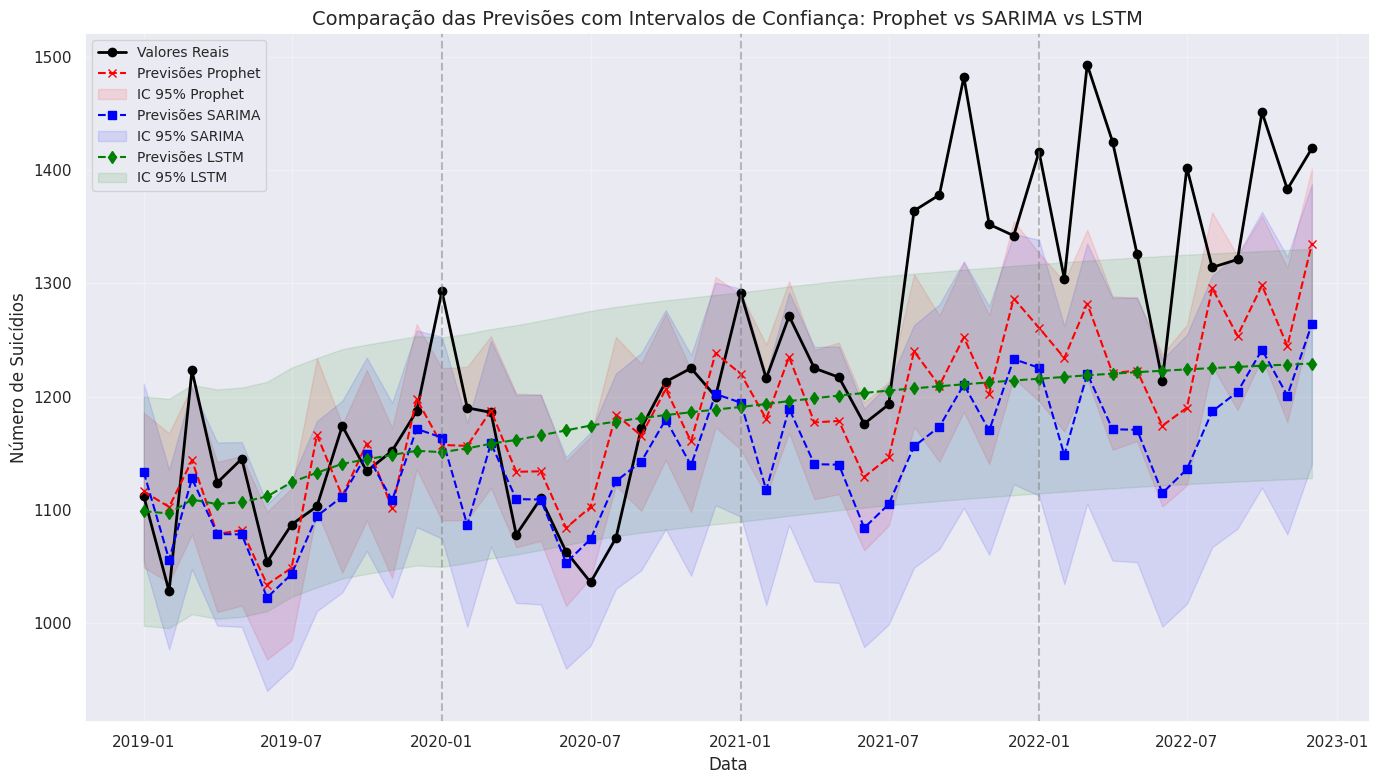

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
forecast_prophet_lower = forecast['yhat_lower'][-48:].values
forecast_prophet_upper = forecast['yhat_upper'][-48:].values

forecast_sarima_lower = forecast_ci.iloc[:, 0].values  # Coluna inferior do intervalo
forecast_sarima_upper = forecast_ci.iloc[:, 1].values  # Coluna superior do intervalo

train_preds = []
for i in range(len(X)):
    pred = model.predict(X[i:i+1])
    train_preds.append(pred[0][0])

train_preds = np.array(train_preds)
train_preds_rescaled = scaler.inverse_transform(train_preds.reshape(-1, 1)).flatten()

train_indices = range(time_steps, len(df_result_before_2019))
true_values = df_result_before_2019['count'].iloc[train_indices].values

residuals = true_values - train_preds_rescaled
std_error = np.std(residuals)

# Intervalo de confiança (95%) para LSTM usando 1.96 * std_error
z_value = 1.96  # Para 95% de confiança
forecast_lstm_lower = df_compare['forecast_lstm'].values - z_value * std_error
forecast_lstm_upper = df_compare['forecast_lstm'].values + z_value * std_error

forecast_lstm_lower = np.maximum(0, forecast_lstm_lower)

# gráfico com intervalos de confiança
plt.figure(figsize=(14, 8))

# Valores reais
plt.plot(df_compare.index, df_compare['count'], label='Valores Reais', marker='o', color='black', linestyle='-', linewidth=2)

# Prophet com intervalo de confiança
plt.plot(df_compare.index, df_compare['forecast'], label='Previsões Prophet', marker='x', color='red', linestyle='--')
plt.fill_between(df_compare.index, forecast_prophet_lower, forecast_prophet_upper, color='red', alpha=0.1, label='IC 95% Prophet')

# SARIMA com intervalo de confiança
plt.plot(df_compare.index, df_compare['forecast_sarima'], label='Previsões SARIMA', marker='s', color='blue', linestyle='--')
plt.fill_between(df_compare.index, forecast_sarima_lower, forecast_sarima_upper, color='blue', alpha=0.1, label='IC 95% SARIMA')

# LSTM com intervalo de confiança
plt.plot(df_compare.index, df_compare['forecast_lstm'], label='Previsões LSTM', marker='d', color='green', linestyle='--')
plt.fill_between(df_compare.index, forecast_lstm_lower, forecast_lstm_upper, color='green', alpha=0.1, label='IC 95% LSTM')

for year in range(2020, 2023):
    plt.axvline(x=pd.Timestamp(f'{year}-01-01'), color='gray', linestyle='--', alpha=0.5)

plt.title('Comparação das Previsões com Intervalos de Confiança: Prophet vs SARIMA vs LSTM', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Número de Suicídios', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('Comparação das Previsões com Intervalos de Confiança.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Comparação das Previsões com Intervalos de Confiança.png')

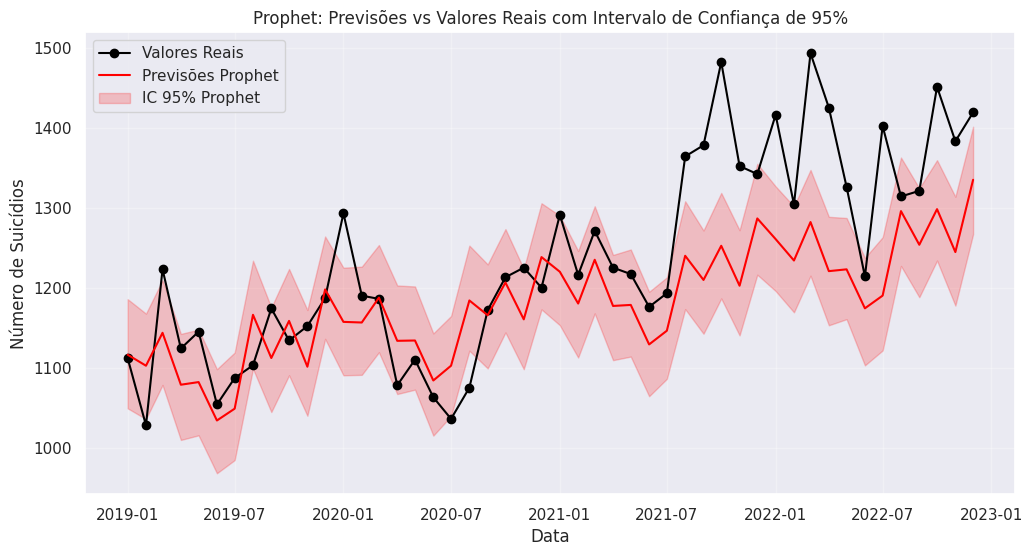

In [ ]:
# Prophet
plt.figure(figsize=(12, 6))
plt.plot(df_compare.index, df_compare['count'], label='Valores Reais', marker='o', color='black')
plt.plot(df_compare.index, df_compare['forecast'], label='Previsões Prophet', color='red')
plt.fill_between(df_compare.index, forecast_prophet_lower, forecast_prophet_upper, color='red', alpha=0.2, label='IC 95% Prophet')
plt.title('Prophet: Previsões vs Valores Reais com Intervalo de Confiança de 95%')
plt.xlabel('Data')
plt.ylabel('Número de Suicídios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('Prophet com IC.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

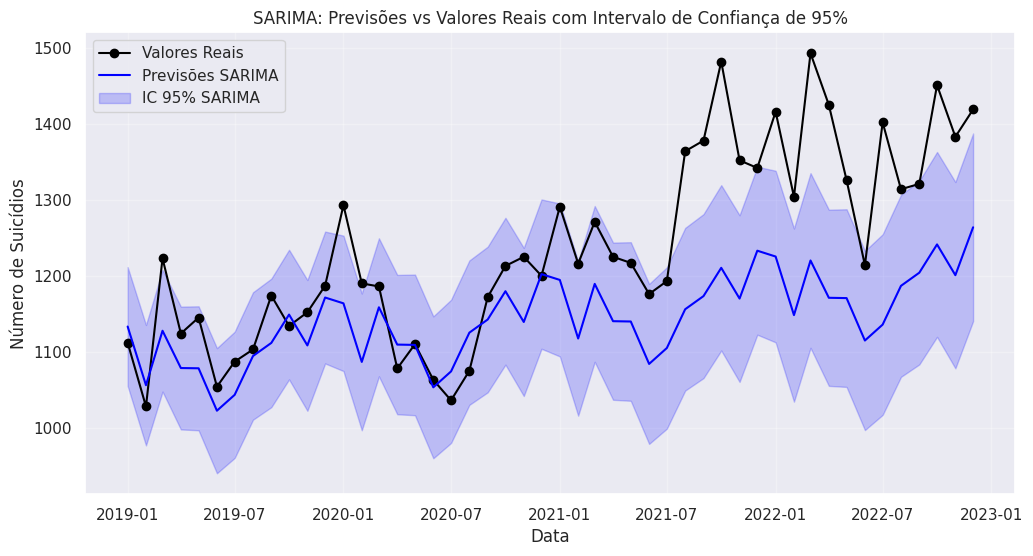

In [ ]:
# SARIMA
plt.figure(figsize=(12, 6))
plt.plot(df_compare.index, df_compare['count'], label='Valores Reais', marker='o', color='black')
plt.plot(df_compare.index, df_compare['forecast_sarima'], label='Previsões SARIMA', color='blue')
plt.fill_between(df_compare.index, forecast_sarima_lower, forecast_sarima_upper, color='blue', alpha=0.2, label='IC 95% SARIMA')
plt.title('SARIMA: Previsões vs Valores Reais com Intervalo de Confiança de 95%')
plt.xlabel('Data')
plt.ylabel('Número de Suicídios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('SARIMA com IC.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

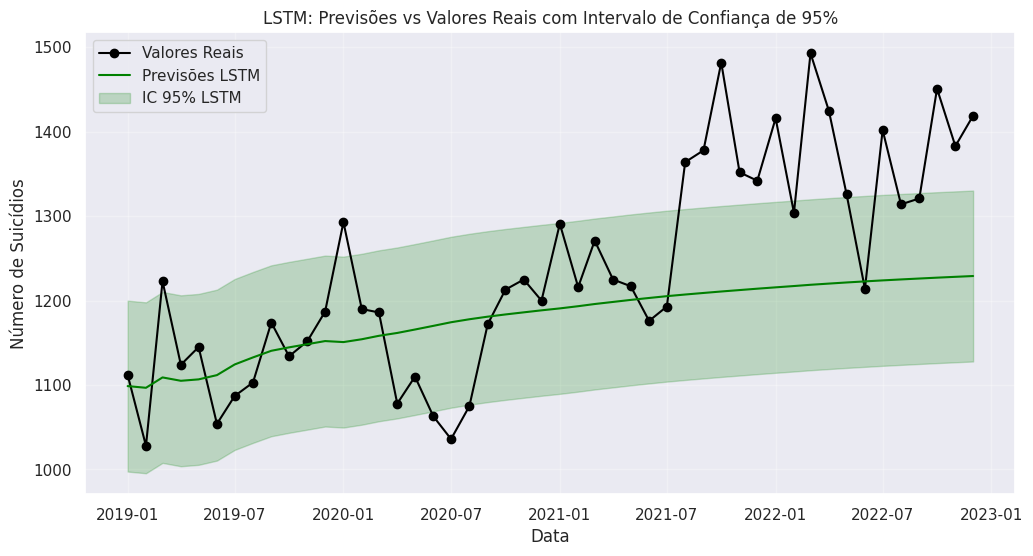

Largura média do intervalo de confiança (Prophet): 132.28
Largura média do intervalo de confiança (SARIMA): 200.24
Largura média do intervalo de confiança (LSTM): 202.44


In [ ]:
# LSTM
plt.figure(figsize=(12, 6))
plt.plot(df_compare.index, df_compare['count'], label='Valores Reais', marker='o', color='black')
plt.plot(df_compare.index, df_compare['forecast_lstm'], label='Previsões LSTM', color='green')
plt.fill_between(df_compare.index, forecast_lstm_lower, forecast_lstm_upper, color='green', alpha=0.2, label='IC 95% LSTM')
plt.title('LSTM: Previsões vs Valores Reais com Intervalo de Confiança de 95%')
plt.xlabel('Data')
plt.ylabel('Número de Suicídios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('LSTM com IC.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

ic_width_prophet = np.mean(forecast_prophet_upper - forecast_prophet_lower)
ic_width_sarima = np.mean(forecast_sarima_upper - forecast_sarima_lower)
ic_width_lstm = np.mean(forecast_lstm_upper - forecast_lstm_lower)

print(f"Largura média do intervalo de confiança (Prophet): {ic_width_prophet:.2f}")
print(f"Largura média do intervalo de confiança (SARIMA): {ic_width_sarima:.2f}")
print(f"Largura média do intervalo de confiança (LSTM): {ic_width_lstm:.2f}")

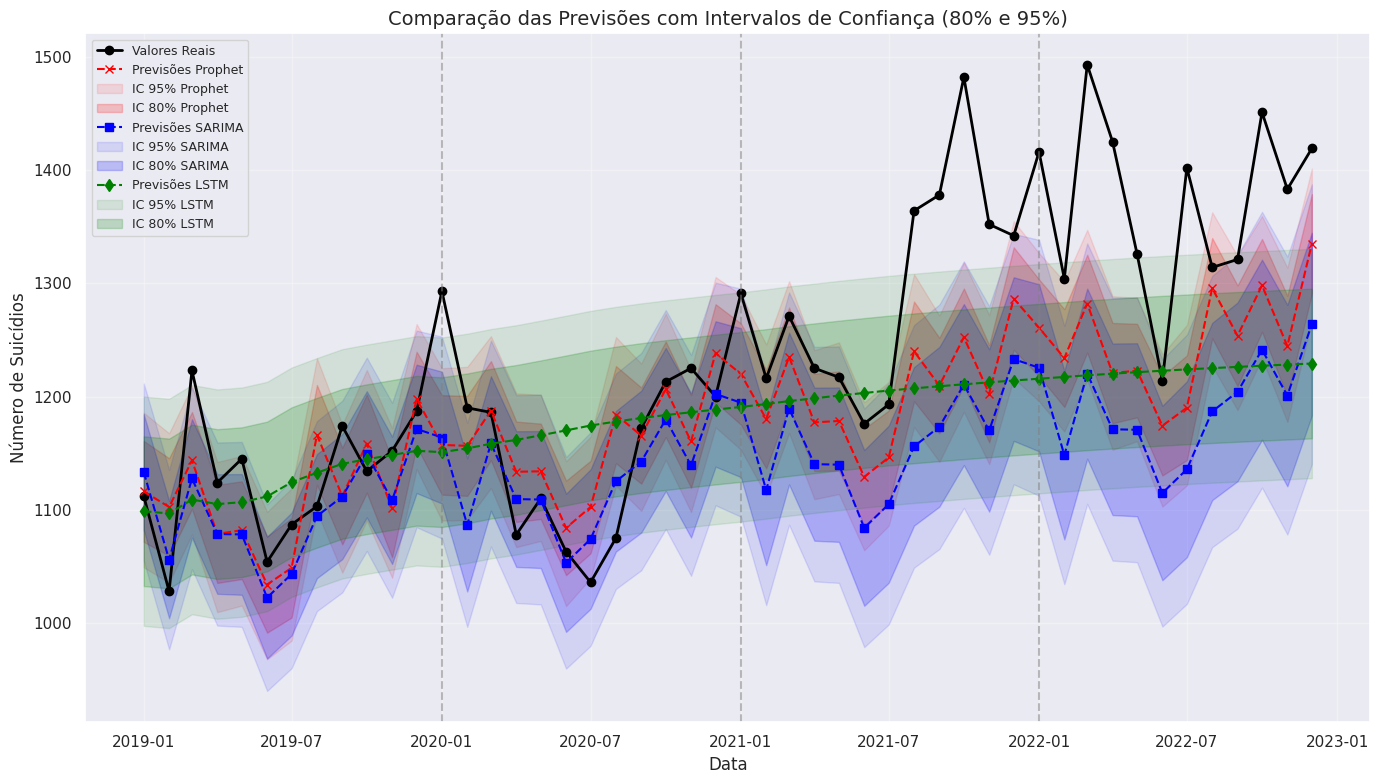

In [ ]:
# intervalos de 95% do Prophet
forecast_prophet_lower_95 = forecast['yhat_lower'][-48:].values
forecast_prophet_upper_95 = forecast['yhat_upper'][-48:].values

# intervalo de 80% para o Prophet
# prophet usa uma distribuição t para calcular os intervalos
# aproximar usando o erro padrão das previsões
forecast_std = (forecast_prophet_upper_95 - forecast_prophet_lower_95) / (2 * 1.96)  # 1.96 é o z-score para 95%
z_80 = 1.28  # z-score para 80%
forecast_prophet_lower_80 = df_compare['forecast'].values - z_80 * forecast_std
forecast_prophet_upper_80 = df_compare['forecast'].values + z_80 * forecast_std

# SARIMA usa distribuição normal, ajustar o z-score
sarima_std = (forecast_sarima_upper - forecast_sarima_lower) / (2 * 1.96)  # Extrai o erro padrão
z_80 = 1.28  # z-score para 80%
forecast_sarima_lower_80 = df_compare['forecast_sarima'].values - z_80 * sarima_std
forecast_sarima_upper_80 = df_compare['forecast_sarima'].values + z_80 * sarima_std

z_95 = 1.96  # Para 95% de confiança
forecast_lstm_lower_95 = df_compare['forecast_lstm'].values - z_95 * std_error
forecast_lstm_upper_95 = df_compare['forecast_lstm'].values + z_95 * std_error

z_80 = 1.28  # Para 80% de confiança
forecast_lstm_lower_80 = df_compare['forecast_lstm'].values - z_80 * std_error
forecast_lstm_upper_80 = df_compare['forecast_lstm'].values + z_80 * std_error

forecast_lstm_lower_95 = np.maximum(0, forecast_lstm_lower_95)
forecast_lstm_lower_80 = np.maximum(0, forecast_lstm_lower_80)
forecast_prophet_lower_80 = np.maximum(0, forecast_prophet_lower_80)
forecast_sarima_lower_80 = np.maximum(0, forecast_sarima_lower_80)

# gráfico com os dois intervalos de confiança (80% e 95%)
plt.figure(figsize=(14, 8))

# Valores reais
plt.plot(df_compare.index, df_compare['count'], label='Valores Reais', marker='o', color='black', linestyle='-', linewidth=2)

# Prophet com intervalos de confiança
plt.plot(df_compare.index, df_compare['forecast'], label='Previsões Prophet', marker='x', color='red', linestyle='--')
plt.fill_between(df_compare.index, forecast_prophet_lower_95, forecast_prophet_upper_95, color='red', alpha=0.1, label='IC 95% Prophet')
plt.fill_between(df_compare.index, forecast_prophet_lower_80, forecast_prophet_upper_80, color='red', alpha=0.2, label='IC 80% Prophet')

# SARIMA com intervalos de confiança
plt.plot(df_compare.index, df_compare['forecast_sarima'], label='Previsões SARIMA', marker='s', color='blue', linestyle='--')
plt.fill_between(df_compare.index, forecast_sarima_lower, forecast_sarima_upper, color='blue', alpha=0.1, label='IC 95% SARIMA')
plt.fill_between(df_compare.index, forecast_sarima_lower_80, forecast_sarima_upper_80, color='blue', alpha=0.2, label='IC 80% SARIMA')

# LSTM com intervalos de confiança
plt.plot(df_compare.index, df_compare['forecast_lstm'], label='Previsões LSTM', marker='d', color='green', linestyle='--')
plt.fill_between(df_compare.index, forecast_lstm_lower_95, forecast_lstm_upper_95, color='green', alpha=0.1, label='IC 95% LSTM')
plt.fill_between(df_compare.index, forecast_lstm_lower_80, forecast_lstm_upper_80, color='green', alpha=0.2, label='IC 80% LSTM')

for year in range(2020, 2023):
    plt.axvline(x=pd.Timestamp(f'{year}-01-01'), color='gray', linestyle='--', alpha=0.5)

plt.title('Comparação das Previsões com Intervalos de Confiança (80% e 95%)', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Número de Suicídios', fontsize=12)
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('Comparação das Previsões com IC 80 e 95 pct.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

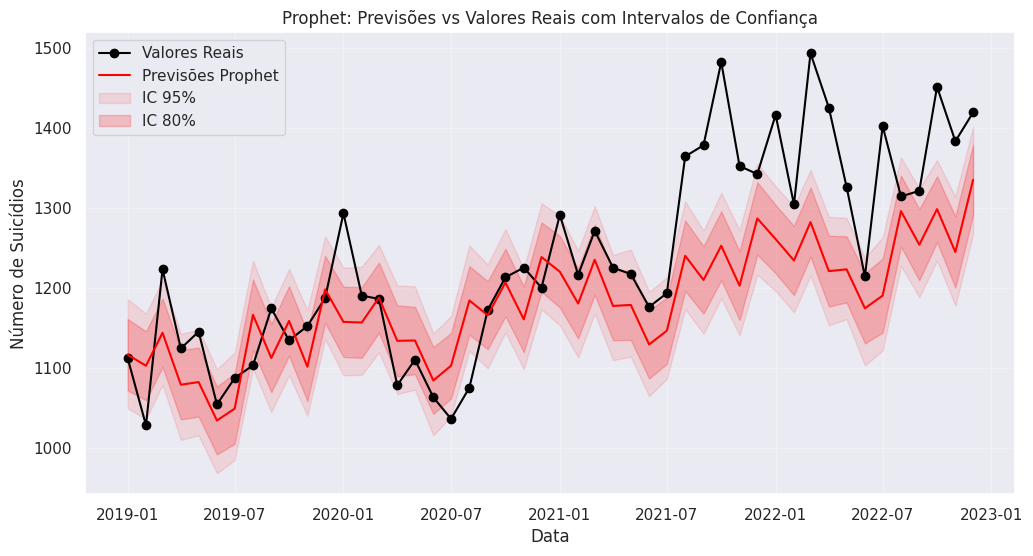

In [ ]:
# gráficos individuais para cada modelo
# mostrando os dois intervalos de confiança

# Prophet
plt.figure(figsize=(12, 6))
plt.plot(df_compare.index, df_compare['count'], label='Valores Reais', marker='o', color='black')
plt.plot(df_compare.index, df_compare['forecast'], label='Previsões Prophet', color='red')
plt.fill_between(df_compare.index, forecast_prophet_lower_95, forecast_prophet_upper_95, color='red', alpha=0.1, label='IC 95%')
plt.fill_between(df_compare.index, forecast_prophet_lower_80, forecast_prophet_upper_80, color='red', alpha=0.2, label='IC 80%')
plt.title('Prophet: Previsões vs Valores Reais com Intervalos de Confiança')
plt.xlabel('Data')
plt.ylabel('Número de Suicídios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('Prophet com IC 80 e 95 pct.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

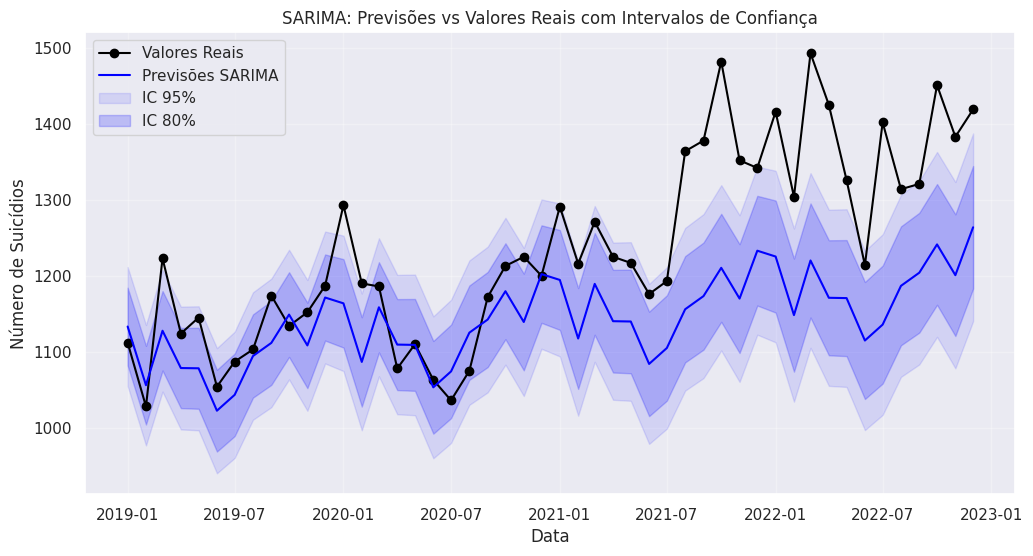

In [ ]:
# SARIMA
plt.figure(figsize=(12, 6))
plt.plot(df_compare.index, df_compare['count'], label='Valores Reais', marker='o', color='black')
plt.plot(df_compare.index, df_compare['forecast_sarima'], label='Previsões SARIMA', color='blue')
plt.fill_between(df_compare.index, forecast_sarima_lower, forecast_sarima_upper, color='blue', alpha=0.1, label='IC 95%')
plt.fill_between(df_compare.index, forecast_sarima_lower_80, forecast_sarima_upper_80, color='blue', alpha=0.2, label='IC 80%')
plt.title('SARIMA: Previsões vs Valores Reais com Intervalos de Confiança')
plt.xlabel('Data')
plt.ylabel('Número de Suicídios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('SARIMA com IC 80 e 95 pct.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

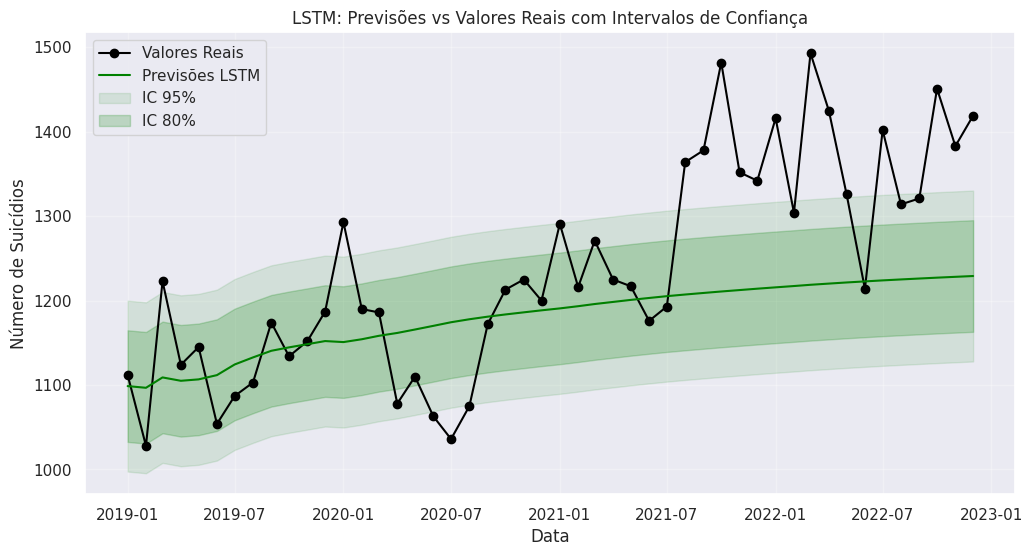

In [ ]:
# LSTM
plt.figure(figsize=(12, 6))
plt.plot(df_compare.index, df_compare['count'], label='Valores Reais', marker='o', color='black')
plt.plot(df_compare.index, df_compare['forecast_lstm'], label='Previsões LSTM', color='green')
plt.fill_between(df_compare.index, forecast_lstm_lower_95, forecast_lstm_upper_95, color='green', alpha=0.1, label='IC 95%')
plt.fill_between(df_compare.index, forecast_lstm_lower_80, forecast_lstm_upper_80, color='green', alpha=0.2, label='IC 80%')
plt.title('LSTM: Previsões vs Valores Reais com Intervalos de Confiança')
plt.xlabel('Data')
plt.ylabel('Número de Suicídios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('LSTM com IC 80 e 95 pct.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Comparação da largura dos intervalos de confiança
ic_width_prophet_95 = np.mean(forecast_prophet_upper_95 - forecast_prophet_lower_95)
ic_width_prophet_80 = np.mean(forecast_prophet_upper_80 - forecast_prophet_lower_80)

ic_width_sarima_95 = np.mean(forecast_sarima_upper - forecast_sarima_lower)
ic_width_sarima_80 = np.mean(forecast_sarima_upper_80 - forecast_sarima_lower_80)

ic_width_lstm_95 = np.mean(forecast_lstm_upper_95 - forecast_lstm_lower_95)
ic_width_lstm_80 = np.mean(forecast_lstm_upper_80 - forecast_lstm_lower_80)

print("Largura média dos intervalos de confiança:")
print(f"Prophet (95%): {ic_width_prophet_95:.2f}")
print(f"Prophet (80%): {ic_width_prophet_80:.2f}")
print(f"SARIMA (95%): {ic_width_sarima_95:.2f}")
print(f"SARIMA (80%): {ic_width_sarima_80:.2f}")
print(f"LSTM (95%): {ic_width_lstm_95:.2f}")
print(f"LSTM (80%): {ic_width_lstm_80:.2f}")

# Calculando proporção de valores reais dentro dos intervalos de confiança
dentro_ic_95_prophet = np.sum((df_compare['count'] >= forecast_prophet_lower_95) &
                            (df_compare['count'] <= forecast_prophet_upper_95))
dentro_ic_80_prophet = np.sum((df_compare['count'] >= forecast_prophet_lower_80) &
                            (df_compare['count'] <= forecast_prophet_upper_80))

dentro_ic_95_sarima = np.sum((df_compare['count'] >= forecast_sarima_lower) &
                           (df_compare['count'] <= forecast_sarima_upper))
dentro_ic_80_sarima = np.sum((df_compare['count'] >= forecast_sarima_lower_80) &
                           (df_compare['count'] <= forecast_sarima_upper_80))

dentro_ic_95_lstm = np.sum((df_compare['count'] >= forecast_lstm_lower_95) &
                         (df_compare['count'] <= forecast_lstm_upper_95))
dentro_ic_80_lstm = np.sum((df_compare['count'] >= forecast_lstm_lower_80) &
                         (df_compare['count'] <= forecast_lstm_upper_80))

total_pontos = len(df_compare)

print("\nPorcentagem de valores reais dentro dos intervalos de confiança:")
print(f"Prophet (95%): {100 * dentro_ic_95_prophet / total_pontos:.2f}%")
print(f"Prophet (80%): {100 * dentro_ic_80_prophet / total_pontos:.2f}%")
print(f"SARIMA (95%): {100 * dentro_ic_95_sarima / total_pontos:.2f}%")
print(f"SARIMA (80%): {100 * dentro_ic_80_sarima / total_pontos:.2f}%")
print(f"LSTM (95%): {100 * dentro_ic_95_lstm / total_pontos:.2f}%")
print(f"LSTM (80%): {100 * dentro_ic_80_lstm / total_pontos:.2f}%")

Largura média dos intervalos de confiança:
Prophet (95%): 132.28
Prophet (80%): 86.38
SARIMA (95%): 200.24
SARIMA (80%): 130.77
LSTM (95%): 202.44
LSTM (80%): 132.21

Porcentagem de valores reais dentro dos intervalos de confiança:
Prophet (95%): 58.33%
Prophet (80%): 35.42%
SARIMA (95%): 64.58%
SARIMA (80%): 37.50%
LSTM (95%): 62.50%
LSTM (80%): 47.92%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


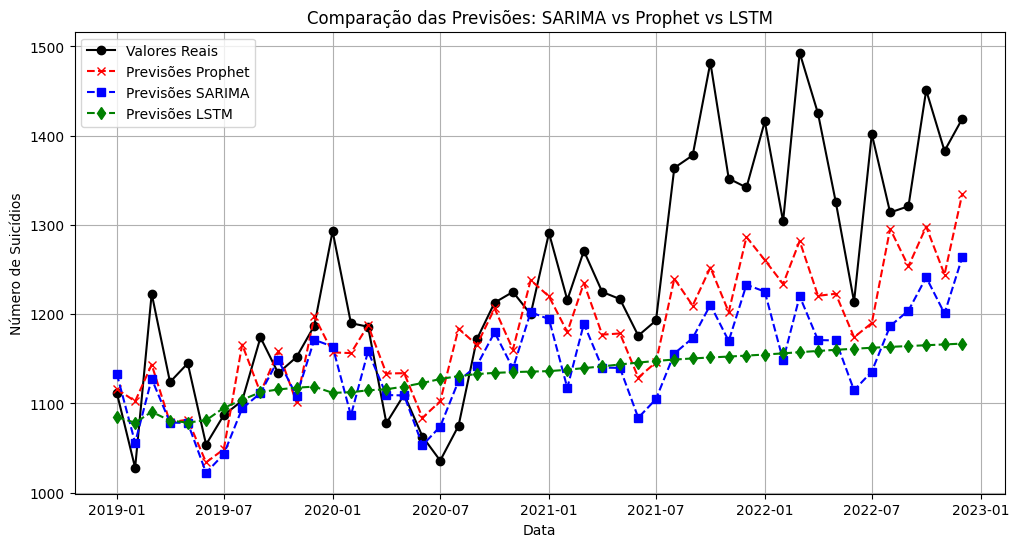

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_compare.index, df_compare['count'], label='Valores Reais', marker='o', color='black', linestyle='-')
plt.plot(df_compare.index, df_compare['forecast'], label='Previsões Prophet', marker='x', color='red', linestyle='--')
plt.plot(df_compare.index, df_compare['forecast_sarima'], label='Previsões SARIMA', marker='s', color='blue', linestyle='--')
plt.plot(df_compare.index, df_compare['forecast_lstm'], label='Previsões LSTM', marker='d', color='green', linestyle='--')


plt.title('Comparação das Previsões: SARIMA vs Prophet vs LSTM')
plt.xlabel('Data')
plt.ylabel('Número de Suicídios')
plt.legend()
plt.grid(True)
plt.savefig('Comparação das Previsões: SARIMA vs Prophet vs LSTM.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Comparação das Previsões: SARIMA vs Prophet vs LSTM.png')

#### XGBoost

In [ ]:
df_teste = pd.read_csv('sim_limpo_e_alterado.csv')

In [ ]:
def classify_diag(causa):
  if str(causa).startswith('X6'):
    return 'A'
  else:
    return 'L'

df_xg = df_teste.copy()
df_xg['diag'] = df_xg['CAUSABAS'].apply(classify_diag)


In [ ]:
df_xg

ano_obito  data_obito CAUSABAS  SEXO  RACACOR  ESC def_loc_ocor  \
0            2022  2022-05-05     X700     1        1    9    Domicílio   
1            2019  2019-10-17     X708     1        4    9       Outros   
2            2019  2019-05-19     X700     1        1    3    Domicílio   
3            2022  2022-04-07     X704     1        4    3  Via Pública   
4            2019  2019-04-23     X680     1        4    3     Hospital   
...           ...         ...      ...   ...      ...  ...          ...   
218702       2010  2010-12-24     X700     1        5    3    Domicílio   
218703       2010  2010-11-21     X699     1        4    3       Outros   
218704       2010  2010-12-29     X700     2        5    3    Domicílio   
218705       2010  2010-12-17     X708     1        5    4    Domicílio   
218706       2010  2010-12-25     X708     1        5    4    Domicílio   

                  res_MUNNOME ocor_SIGLA_UF  idade_obito_anos diag  
0                Nova Bréscia            RS              60.0    L  
1                      Coreaú            CE              27.0    L  
2                     Caucaia            CE              29.0    L  
3                   Três Rios            RJ              41.0    L  
4                    Apuiarés            CE              42.0    A  
...                       ...           ...               ...  ...  
218702      Benjamin Constant            AM              45.0    L  
218703              Tabatinga            AM              29.0    A  
218704              Tabatinga            AM              12.0    L  
218705              Tabatinga            AM              24.0    L  
218706  São Paulo de Olivença            AM              20.0    L  

[218707 rows x 11 columns]

In [ ]:
df_xg['diag'].value_counts()

diag
L    190540
A     28167
Name: count, dtype: int64

In [ ]:
df_xg.shape

(218707, 11)

In [ ]:
proportions = df_xg['diag'].value_counts(normalize=True) * 100
print(proportions)

diag
L    87.121126
A    12.878874
Name: proportion, dtype: float64


In [ ]:
label_columns = ['SEXO', 'RACACOR', 'ESC', 'def_loc_ocor', 'res_MUNNOME', 'ocor_SIGLA_UF']
label_encoder = LabelEncoder()

for col in label_columns:
    df_xg[col] = label_encoder.fit_transform(df_xg[col].astype(str))

In [ ]:
df_xg

ano_obito  data_obito CAUSABAS  SEXO  RACACOR  ESC  def_loc_ocor  \
0            2022  2022-05-05     X700     1        0    5             0   
1            2019  2019-10-17     X708     1        3    5             4   
2            2019  2019-05-19     X700     1        0    2             0   
3            2022  2022-04-07     X704     1        3    2             5   
4            2019  2019-04-23     X680     1        3    2             1   
...           ...         ...      ...   ...      ...  ...           ...   
218702       2010  2010-12-24     X700     1        4    2             0   
218703       2010  2010-11-21     X699     1        3    2             4   
218704       2010  2010-12-29     X700     2        4    2             0   
218705       2010  2010-12-17     X708     1        4    3             0   
218706       2010  2010-12-25     X708     1        4    3             0   

        res_MUNNOME  ocor_SIGLA_UF  idade_obito_anos diag  
0              3131             22              60.0    L  
1              1264              5              27.0    L  
2              1083              5              29.0    L  
3              4992             18              41.0    L  
4               239              5              42.0    A  
...             ...            ...               ...  ...  
218702          539              2              45.0    L  
218703         4815              2              29.0    A  
218704         4815              2              12.0    L  
218705         4815              2              24.0    L  
218706         4743              2              20.0    L  

[218707 rows x 11 columns]

In [ ]:
df_xg['diag'] = df_xg['diag'].map({'A': 0, 'L': 1})


In [ ]:
df_xg_treino_teste = df_xg.copy()

df_xg_treino_teste.drop(columns=['CAUSABAS', 'data_obito', 'ano_obito'], inplace=True)

X = df_xg_treino_teste.drop('diag', axis=1)
y = df_xg_treino_teste['diag']

In [ ]:
df_xg_treino_teste

SEXO  RACACOR  ESC  def_loc_ocor  res_MUNNOME  ocor_SIGLA_UF  \
0          1        0    5             0         3131             22   
1          1        3    5             4         1264              5   
2          1        0    2             0         1083              5   
3          1        3    2             5         4992             18   
4          1        3    2             1          239              5   
...      ...      ...  ...           ...          ...            ...   
218702     1        4    2             0          539              2   
218703     1        3    2             4         4815              2   
218704     2        4    2             0         4815              2   
218705     1        4    3             0         4815              2   
218706     1        4    3             0         4743              2   

        idade_obito_anos  diag  
0                   60.0     1  
1                   27.0     1  
2                   29.0     1  
3                   41.0     1  
4                   42.0     0  
...                  ...   ...  
218702              45.0     1  
218703              29.0     0  
218704              12.0     1  
218705              24.0     1  
218706              20.0     1  

[218707 rows x 8 columns]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
train_data = pd.concat([X_train, y_train], axis=1)

In [ ]:
from sklearn.utils import resample

majority_class = train_data[train_data['diag'] == 1]
minority_class = train_data[train_data['diag'] == 0]

majority_class_undersampled = resample(majority_class,
                                       replace=False,
                                       n_samples=len(minority_class),
                                       random_state=42)

df_xg_undersampled = pd.concat([majority_class_undersampled, minority_class])

print(df_xg_undersampled['diag'].value_counts())

diag
1    19798
0    19798
Name: count, dtype: int64


In [ ]:
new_X_train = df_xg_undersampled.drop('diag', axis=1)
new_y_train = df_xg_undersampled['diag']

In [ ]:
model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)

model.fit(new_X_train, new_y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

report = classification_report(y_test, y_pred)
print("Relatório de Classificação:")
print(report)

Acurácia: 0.8152
Matriz de Confusão:
[[ 6154  2215]
 [ 9913 47331]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.38      0.74      0.50      8369
           1       0.96      0.83      0.89     57244

    accuracy                           0.82     65613
   macro avg       0.67      0.78      0.70     65613
weighted avg       0.88      0.82      0.84     65613



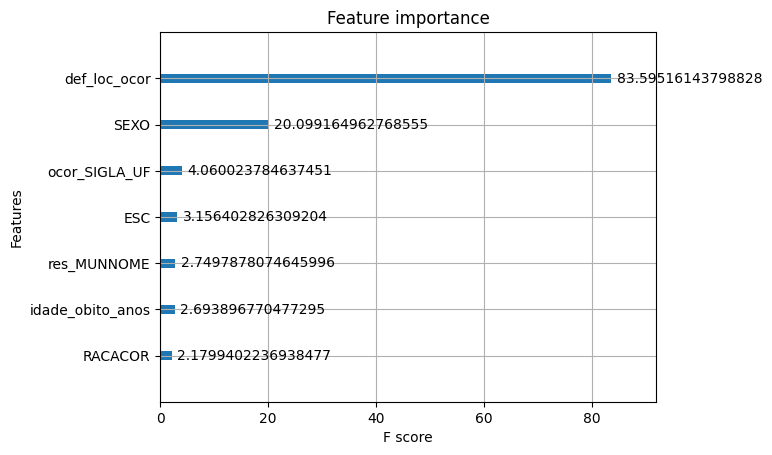

In [ ]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.show()


In [ ]:
import numpy as np
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Importância das variáveis:")
for i in range(X.shape[1]):
    print(f"{X.columns[indices[i]]}: {importances[indices[i]]}")


Importância das variáveis:
def_loc_ocor: 0.7052398324012756
SEXO: 0.16956402361392975
ocor_SIGLA_UF: 0.034251868724823
ESC: 0.026628587394952774
res_MUNNOME: 0.023198232054710388
idade_obito_anos: 0.022726714611053467
RACACOR: 0.01839078590273857


#### Modelo comparativo ao XGBoost: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(new_X_train, new_y_train)

y_pred_rf = rf_model.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


print("Desempenho do Random Forest:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precisão: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]):.2f}")

print("\nDesempenho do XGBoost:")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precisão: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.2f}")


Desempenho do Random Forest:
Acurácia: 0.77
Precisão: 0.95
Recall: 0.77
F1-Score: 0.85
ROC-AUC: 0.81

Desempenho do XGBoost:
Acurácia: 0.82
Precisão: 0.96
Recall: 0.83
F1-Score: 0.89
ROC-AUC: 0.84


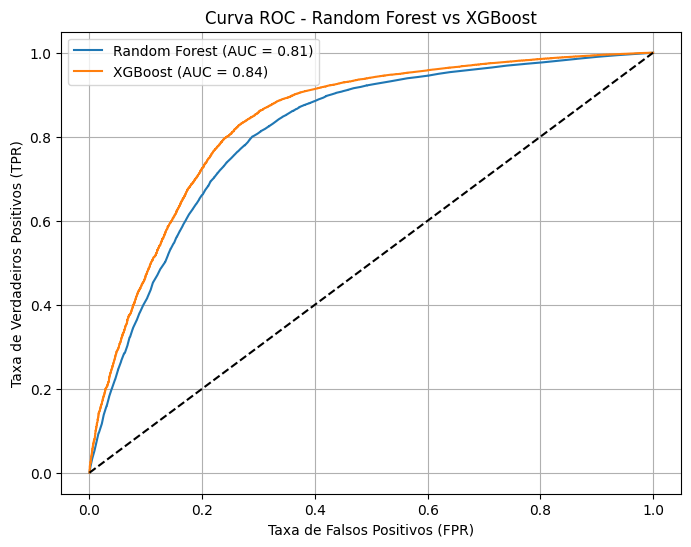

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])))
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost (AUC = {:.2f})'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Random Forest vs XGBoost')
plt.legend()
plt.grid(True)

plt.savefig('Curva ROC - Random Forest vs XGBoost.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Curva ROC - Random Forest vs XGBoost.png')


In [ ]:
importances = rf_model.feature_importances_

feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)


            Feature  Importance
3      def_loc_ocor    0.285943
4       res_MUNNOME    0.249096
6  idade_obito_anos    0.236263
5     ocor_SIGLA_UF    0.092915
2               ESC    0.055132
0              SEXO    0.050240
1           RACACOR    0.030411


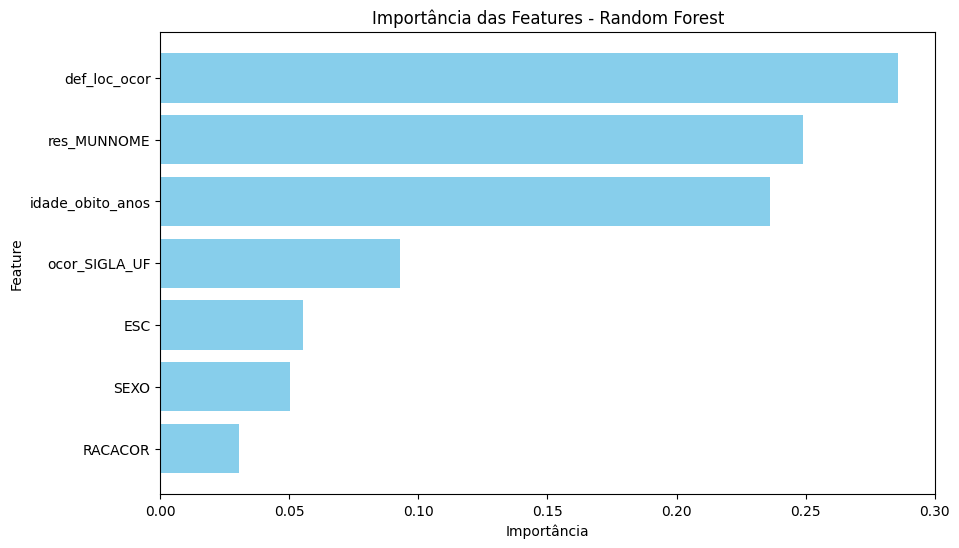

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.title('Importância das Features - Random Forest')
plt.gca().invert_yaxis()
plt.show()


### Múltiplas execuções

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

importances = []
importances_rf = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
accuracy_scores_rf = []
precision_scores_rf = []
recall_scores_rf = []
f1_scores_rf = []
roc_auc_scores_rf = []
y_true_all = []
y_pred_proba_all = []
y_pred_rf_proba_all = []

n_runs = 100

feature_names = X.columns.tolist()

for i in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    train_data = pd.concat([X_train, y_train], axis=1)
    majority_class = train_data[train_data['diag'] == 1]
    minority_class = train_data[train_data['diag'] == 0]

    majority_class_undersampled = resample(majority_class,
                                          replace=False,
                                          n_samples=len(minority_class),
                                          random_state=i)

    df_xg_undersampled = pd.concat([majority_class_undersampled, minority_class])
    new_X_train = df_xg_undersampled.drop('diag', axis=1)
    new_y_train = df_xg_undersampled['diag']

    model = xgb.XGBClassifier(objective='binary:logistic')

    model.fit(new_X_train, new_y_train)

    rf_model = RandomForestClassifier(n_estimators=100, random_state=i)
    rf_model.fit(new_X_train, new_y_train)

    # Capturando a importância das variáveis
    importances.append(model.feature_importances_)
    importances_rf.append(rf_model.feature_importances_)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Para ROC AUC, precisamos da probabilidade da classe positiva

    y_pred_rf = rf_model.predict(X_test)
    y_pred_rf_proba = rf_model.predict_proba(X_test)[:, 1]  # Para ROC AUC, precisamos da probabilidade da classe positiva

    y_true_all.append(y_test)
    y_pred_proba_all.append(y_pred_proba)
    y_pred_rf_proba_all.append(y_pred_rf_proba)

    # Calculando as métricas
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_proba))

    accuracy_scores_rf.append(accuracy_score(y_test, y_pred_rf))
    precision_scores_rf.append(precision_score(y_test, y_pred_rf))
    recall_scores_rf.append(recall_score(y_test, y_pred_rf))
    f1_scores_rf.append(f1_score(y_test, y_pred_rf))
    roc_auc_scores_rf.append(roc_auc_score(y_test, y_pred_rf_proba))

# Calculando a importância média e o desvio padrão
mean_importances = np.mean(importances, axis=0)
mean_importances_rf = np.mean(importances_rf, axis=0)
std_importances = np.std(importances, axis=0)
std_importances_rf = np.std(importances_rf, axis=0)

# Exibindo os resultados
for i, col in enumerate(feature_names):
    print(f"Variável: {col}, Importância média: {mean_importances[i]:.4f}, Desvio padrão: {std_importances[i]:.4f}")
    print(f"Variável: {col}, Importância média: {mean_importances_rf[i]:.4f}, Desvio padrão: {std_importances_rf[i]:.4f}")

print(f"Acurácia: Média = {np.mean(accuracy_scores):.4f}, Desvio Padrão = {np.std(accuracy_scores):.4f}")
print(f"Precisão: Média = {np.mean(precision_scores):.4f}, Desvio Padrão = {np.std(precision_scores):.4f}")
print(f"Recall: Média = {np.mean(recall_scores):.4f}, Desvio Padrão = {np.std(recall_scores):.4f}")
print(f"F1-Score: Média = {np.mean(f1_scores):.4f}, Desvio Padrão = {np.std(f1_scores):.4f}")
print(f"ROC AUC: Média = {np.mean(roc_auc_scores):.4f}, Desvio Padrão = {np.std(roc_auc_scores):.4f}")

print(f"Acurácia: Média = {np.mean(accuracy_scores_rf):.4f}, Desvio Padrão = {np.std(accuracy_scores_rf):.4f}")
print(f"Precisão: Média = {np.mean(precision_scores_rf):.4f}, Desvio Padrão = {np.std(precision_scores_rf):.4f}")
print(f"Recall: Média = {np.mean(recall_scores_rf):.4f}, Desvio Padrão = {np.std(recall_scores_rf):.4f}")
print(f"F1-Score: Média = {np.mean(f1_scores_rf):.4f}, Desvio Padrão = {np.std(f1_scores_rf):.4f}")
print(f"ROC AUC: Média = {np.mean(roc_auc_scores_rf):.4f}, Desvio Padrão = {np.std(roc_auc_scores_rf):.4f}")


Variável: SEXO, Importância média: 0.1573, Desvio padrão: 0.0122
Variável: SEXO, Importância média: 0.0481, Desvio padrão: 0.0018
Variável: RACACOR, Importância média: 0.0235, Desvio padrão: 0.0017
Variável: RACACOR, Importância média: 0.0292, Desvio padrão: 0.0009
Variável: ESC, Importância média: 0.0280, Desvio padrão: 0.0017
Variável: ESC, Importância média: 0.0545, Desvio padrão: 0.0012
Variável: def_loc_ocor, Importância média: 0.7007, Desvio padrão: 0.0139
Variável: def_loc_ocor, Importância média: 0.2905, Desvio padrão: 0.0037
Variável: res_MUNNOME, Importância média: 0.0258, Desvio padrão: 0.0012
Variável: res_MUNNOME, Importância média: 0.2502, Desvio padrão: 0.0017
Variável: ocor_SIGLA_UF, Importância média: 0.0387, Desvio padrão: 0.0020
Variável: ocor_SIGLA_UF, Importância média: 0.0933, Desvio padrão: 0.0017
Variável: idade_obito_anos, Importância média: 0.0258, Desvio padrão: 0.0013
Variável: idade_obito_anos, Importância média: 0.2342, Desvio padrão: 0.0026
Acurácia: Médi

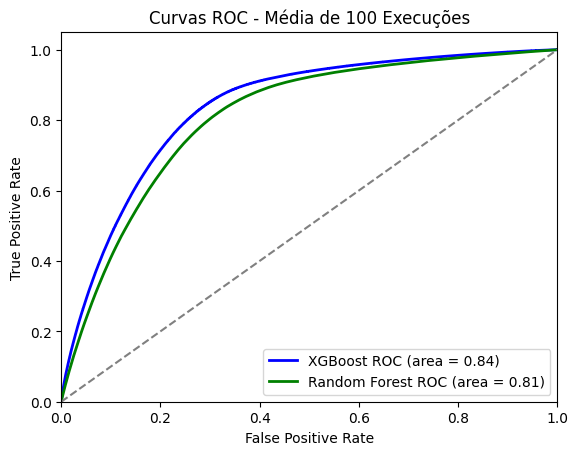

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import roc_curve, auc

# Converter listas para arrays concatenados
# y_true_all = np.concatenate(y_true_all)
# y_pred_proba_all = np.concatenate(y_pred_proba_all)
# y_pred_rf_proba_all = np.concatenate(y_pred_rf_proba_all)

# Gerar a curva ROC para o modelo XGBoost
fpr, tpr, _ = roc_curve(y_true_all, y_pred_proba_all)
roc_auc = auc(fpr, tpr)

# Gerar a curva ROC para o modelo Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_true_all, y_pred_rf_proba_all)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotar as curvas ROC para ambos os modelos
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'XGBoost ROC (area = {roc_auc:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest ROC (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC - Média de 100 Execuções')
plt.legend(loc="lower right")

plt.savefig('Curva ROC - Random Forest vs XGBoost.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

files.download('Curva ROC - Random Forest vs XGBoost.png')